In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import scipy as sp
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras import Model
import unicodedata
import time
import tensorflow as tf

In [3]:
n_mels = 80
fs = 22050
frame_length_ms=50
frame_shift_ms=12.5
nsc = int(22050 * frame_length_ms / 1000)
nov = nsc - int(22050 * frame_shift_ms / 1000)
nhop = int(22050 * frame_shift_ms / 1000)
eps = 1e-10
db_ref = 100

chars = ' ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz!\'(),-.:;? '

num_tokens = len(chars)

embed_size = 256

K = 16

num_conv1d_filters = 128

prenet_size = [256, 128]

num_enc_proj_filters = [128, 128]

enc_highway_depth = 128

enc_bidirection_rnn_depth = 128 # 128 * 2

attention_depth = 128

dec_rnn_depth = [256, 256]

attention_rnn_depth = 256

dec_prenet_size = [256, 128]

r = 6

In [4]:
meta_path = "../datasets/metadata.csv"
# meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"


with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

dataset_size = len(metadata)

In [5]:
# character_length_ = list()
# file_length_ = list()
# division_length_ = list()

# wave_name_list = []

# for data in metadata:
#     wav_name = '{}.wav'.format(data[0])
#     wave_name_list.append(wav_name)
    
# data_folder = "../datasets/wavs"

# for i in tqdm(range(len(metadata))):
#     wav_path = os.path.join(data_folder, wave_name_list[i])
#     y, sr = librosa.core.load(wav_path)
    
#     character_length_.append(len(metadata[i, 1]))
#     file_length_.append(len(y) / sr)
#     division_length_.append(1000 * (len(y) / sr) / len(metadata[i, 1]))

In [6]:
# bins = range(0, 200, 5)
# plt.hist(division_length_, bins)

# plt.show()

In [7]:
meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"


with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])
#     hours = sum((int(x[2]) for x in metadata)) * frame_shift_ms / (3600 * 1000)
#     log('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))

# metadata = metadata[:32, :2]

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [8]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))
    
#     if i not in error_jamos:
    for char in metadata[i, 3]:
        if char not in unicode_jamo_list:
            unicode_jamo_list.append(char)

In [9]:
unicode_jamo_list.sort()
print(unicode_jamo_list)
print(len(unicode_jamo_list))

chars = unicode_jamo_list + ['<end>']

print(chars)

num_tokens = len(chars) + 1

[' ', '!', ',', '.', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆴ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
69
[' ', '!', ',', '.', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆴ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ', '<end>']


In [10]:
unicode_jamo_list[1] == '!'

True

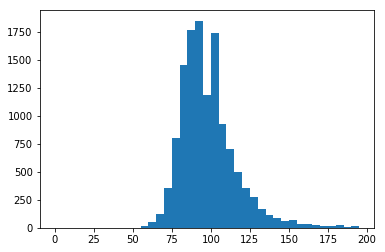

In [11]:
# plt.plot(character_length)
bins = range(0, 200, 5)
plt.hist(division_length, bins)

plt.show()

In [12]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])
    
data_folder = "D:/korean-single-speaker-speech-dataset/kss"
specgram_folder = "D:/korean-single-speaker-speech-dataset/kss/specgrams"
mel_folder = "D:/korean-single-speaker-speech-dataset/kss/mels"

In [13]:
ratio = list()

for i, wav_name in tqdm(enumerate(wave_name_list)):
    
    mel_path = os.path.join(mel_folder, wav_name.replace('.wav', '.npy'))
    mel_target = np.load(mel_path)    
    ratio.append(mel_target.shape[1]/ len(metadata[i][3]))
    
ratio = np.asarray(ratio)

print(metadata.shape)
metadata = np.delete(metadata, np.where(ratio < 6)[0], axis = 0)
print(metadata.shape)  

for data in metadata:
    wave_name_list.append(data[0])


(12833, 5)
(12332, 5)


In [14]:
"""

Preprocessing Step

"""

# for i, wav_name in tqdm(enumerate(wave_name_list)):
#     wav_path = os.path.join(data_folder, wav_name)
    
#     npy_name = wav_name.replace('.wav', '.npy')
    
#     specgram_path = os.path.join(specgram_folder, npy_name)
#     mel_path = os.path.join(mel_folder, npy_name)
    
#     y, sr = librosa.core.load(wav_path)
    
#     f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)

#     Sxx = np.abs(Zxx)
#     Sxx = np.maximum(Sxx, eps)

#     # plt.figure(figsize=(20,20))
#     # plt.imshow(20*np.log10(Sxx), origin='lower')
#     # plt.colorbar()
#     # plt.show()

#     mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)

#     mel_specgram = np.matmul(mel_filters, Sxx)

#     log_specgram = 20*np.log10(Sxx)

#     norm_log_specgram = (log_specgram + db_ref) / db_ref

#     log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))

#     norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref
    
# #     np.save(specgram_path, norm_log_specgram)
# #     np.save(mel_path, norm_log_mel_specgram)
#     np.save(specgram_path, Sxx)
#     np.save(mel_path, norm_log_mel_specgram)
    
# #     print(norm_log_mel_specgram.shape[1])

#     if i % 1000 == 0:

#         plt.figure(figsize=(16,9))
#         plt.imshow(Sxx, origin='lower', aspect='auto')
#         plt.colorbar()
#         plt.show()

#         plt.figure(figsize=(16,9))
#         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
#         plt.colorbar()
#         plt.show()    
# #     break

'\n\nPreprocessing Step\n\n'

In [15]:
embedding_layer = tf.keras.layers.Embedding(num_tokens, embed_size)

def initialize_GO_frame(batch_size, n_mels):
    return tf.zeros((batch_size, r, n_mels))


def flatten_r_frame(input_tensor, batch_size):
    return tf.reshape(input_tensor, [batch_size, 1, -1])


class Conv1D_Bank(tf.keras.Model):
    
    def __init__(self, num_filters, K):
        super(Conv1D_Bank, self).__init__()
        
        self.K = K
        
        self.conv1d_filters = [tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=k+1, filters=num_filters, padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('relu')])
                               for k in range(K)]
        
    def call(self, input_tensor):
        
        intermediate_results = []
        
        for k in range(self.K):
            conv_k_result = self.conv1d_filters[k](input_tensor)
            intermediate_results.append(conv_k_result)
        
        output_tensor = tf.concat(intermediate_results, axis = -1) 
        
        return output_tensor
    
class HighwayNet(tf.keras.Model):
    def __init__(self, num_units):
        super(HighwayNet, self).__init__()
        self.T = tf.keras.layers.Dense(units=num_units, activation='sigmoid',
                                        bias_initializer=tf.constant_initializer(-1.0))
        self.H = tf.keras.layers.Dense(units=num_units, activation='relu')

    def call(self, input_tensor):
        output_tensor = self.H(input_tensor) * self.T(input_tensor) + input_tensor * (1 - self.T(input_tensor))
        return output_tensor
    
'''
https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention

'''
    
class BahdanauAttention(tf.keras.Model):
    def __init__(self):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(attention_depth)
        self.W2 = tf.keras.layers.Dense(attention_depth)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        context_vector = tf.expand_dims(context_vector, axis=1)

        return context_vector, attention_weights
    
class ResidualGRU(tf.keras.Model):
    def __init__(self, units, return_sequences, recurrent_initializer='glorot_uniform'):
        super(ResidualGRU, self).__init__()
        self.units = units
        self.gru_layer = tf.keras.layers.GRU(units, return_sequences=True, recurrent_initializer=recurrent_initializer)

    def call(self, input_tensor, initial_state):
        output_tensor = self.gru_layer(input_tensor, initial_state = initial_state)
        
        residual_ouput_tensor = tf.add(output_tensor, input_tensor[:, :, :self.units])
        
        return residual_ouput_tensor
    
    
class StackedResidualRNN(tf.keras.Model):
    def __init__(self):
        super(StackedResidualRNN, self).__init__()
        self.depth = dec_rnn_depth
        self.residual_grues = [ResidualGRU(dec_rnn_depth[0], return_sequences=True, recurrent_initializer='glorot_uniform'),
                               ResidualGRU(dec_rnn_depth[1], return_sequences=True, recurrent_initializer='glorot_uniform')]

    def call(self, input_tensor, hidden_states):

        for i, residual_gru in enumerate(self.residual_grues):
            output_tensor = residual_gru(input_tensor, initial_state=hidden_states[i])
            hidden_states[i] = tf.reshape(output_tensor, [output_tensor.shape[0], -1])

        return output_tensor, hidden_states
    
    def initialize_hidden_states(self, batch_size):
        return [tf.zeros((batch_size, dec_rnn_depth[0])), tf.zeros((batch_size, dec_rnn_depth[1]))]      

class AttentionRNN(tf.keras.Model):
    def __init__(self):
        super(AttentionRNN, self).__init__()
        self.depth = attention_rnn_depth
        self.gru_cell = tf.keras.layers.GRU(self.depth, return_sequences=True, recurrent_initializer='glorot_uniform')

    def call(self, input_tensor, initial_state):
        output_tensor = self.gru_cell(input_tensor, initial_state=initial_state)
        hidden_state = output_tensor
        hidden_state = tf.reshape(hidden_state, [hidden_state.shape[0], -1])

        return output_tensor, hidden_state
    
    def initialize_hidden_state(self, batch_size):
        return tf.zeros((batch_size, self.depth))      

class DecoderRNN(tf.keras.Model):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        self.dec_rnn_depth = dec_rnn_depth
        self.att_rnn_depth = attention_rnn_depth
        
        self.attention_rnn_layer = AttentionRNN()
        self.residual_rnn_layers = StackedResidualRNN()
        
    def call(self, input_tensor, hidden_states, context_vector):
                
        state, hidden_states[0] = self.attention_rnn_layer(input_tensor, initial_state=hidden_states[0])
        
        res_rnn_input_tensor = tf.concat([state, context_vector], axis=-1)
        
        output_tensor, hidden_states[1:3] = self.residual_rnn_layers(res_rnn_input_tensor, hidden_states[1:3])
        
        return output_tensor, hidden_states
    
    def initialize_hidden_states(self, batch_size):
        hidden_states = [self.attention_rnn_layer.initialize_hidden_state(batch_size)] + self.residual_rnn_layers.initialize_hidden_states(batch_size)
        return hidden_states
    
class DecoderPrenet(tf.keras.Model):
    def __init__(self):
        super(DecoderPrenet, self).__init__()
        self.decoder_prenet_layer = tf.keras.Sequential([tf.keras.layers.Dense(dec_prenet_size[0]),
                         tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.Activation('relu'),
                         tf.keras.layers.Dropout(0.5),
                         tf.keras.layers.Dense(dec_prenet_size[1]),
                         tf.keras.layers.BatchNormalization(),
                         tf.keras.layers.Activation('relu'),
                         tf.keras.layers.Dropout(0.5)])
        
    def call(self, input_tensor):
        output_tensor = self.decoder_prenet_layer(input_tensor)
        return output_tensor
        
class MelPredictor(tf.keras.Model):
    def __init__(self):
        super(MelPredictor, self).__init__()
        self.mel_dense_layers = [tf.keras.layers.Dense(n_mels) for i in range(r)]
        self.r = r
    
    def call(self, input_tensor):
        
        output = []
        
        for i, dense_layer in enumerate(self.mel_dense_layers):
            output.append(dense_layer(input_tensor))
            
        output_tensor = tf.concat(output, axis=1)
        
        return output_tensor
    
class CBHG(tf.keras.Model):
    def __init__(self, num_conv1d_filters, K, num_proj_filters, highway_depth, bidirection_rnn_depth):
        super(CBHG, self).__init__()
        self.conv1d_bank = Conv1D_Bank(num_conv1d_filters, K)
        self.max_pooling_layer = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')
        self.projection_layer = tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=3, filters=num_proj_filters[0], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('relu'),
                                                   tf.keras.layers.Conv1D(kernel_size=3, filters=num_proj_filters[1], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('linear')
                                                   ])
        
        self.highway_preprocess_layer = tf.keras.layers.Dense(highway_depth)
        
        self.highway_layer = tf.keras.Sequential([HighwayNet(highway_depth) for i in range(4)])
        
        self.bi_gru_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(bidirection_rnn_depth, return_sequences=True), merge_mode="concat")

        
    def call(self, input_tensor):
        
        bank_output = self.conv1d_bank(input_tensor)
        max_pool_output = self.max_pooling_layer(bank_output) 
        projection_output = self.projection_layer(max_pool_output)
        
        residual_output = tf.add(projection_output, input_tensor)
        
        highway_intput = self.highway_preprocess_layer(residual_output)
        highway_output = self.highway_layer(highway_intput)
        output_tensor = self.bi_gru_layer(highway_output)
        
        return output_tensor
        

class Tacotron():
    
    def __init__(self):
        super(Tacotron, self).__init__()
        
        self.embedding_layer = tf.keras.layers.Embedding(num_tokens, embed_size) 

        self.encoder_prenet_layer = tf.keras.Sequential([tf.keras.layers.Dense(prenet_size[0], input_shape=(None, embed_size)),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Activation('relu'),
                                 tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.Dense(prenet_size[1]),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.Activation('relu'),
                                 tf.keras.layers.Dropout(0.5)], name='Encoder_Prenet')
    
        self.encoder_conv_bank_layer = Conv1D_Bank(num_conv1d_filters, K)
        
        self.enc_max_pooling_layer = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')
        
        self.enc_proj_layer = tf.keras.Sequential([tf.keras.layers.Conv1D(kernel_size=3, filters=num_enc_proj_filters[0], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('relu'),
                                                   tf.keras.layers.Conv1D(kernel_size=3, filters=num_enc_proj_filters[1], padding='same'),
                                                   tf.keras.layers.BatchNormalization(),
                                                   tf.keras.layers.Activation('linear')
                                                   ])
        
        self.enc_highway_layer = tf.keras.Sequential([HighwayNet(128) for i in range(4)])
    
        self.enc_bi_rnn_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(enc_bidirection_rnn_depth, return_sequences=True), merge_mode="concat")

        self.attention_layer = BahdanauAttention()
        
        self.decoder_rnn_layer = DecoderRNN()
        
        self.decoder_prenet_layer = DecoderPrenet()
        
        self.mel_pred_layer = MelPredictor()
        
        self.post_processing_cbhg = CBHG(128, 8, (256, 80), 128, 128)
        
        self.final_dense_layer = tf.keras.layers.Dense(552)
        
        self.L1 = tf.keras.losses.MeanAbsoluteError()
        
#         self.L2 = tf.keras.losses.MeanSquaredError()

        self.optimizer = tf.keras.optimizers.Adam()
     
#     @tf.function
    def train(self, mel, linear, input_tensor):
        
        batch_size = input_tensor.shape[0]
        sequence_length = input_tensor.shape[1]
        
        with tf.GradientTape() as tape:
            
            embedded = self.embedding_layer(input_tensor)
            encoded = self.encoder_prenet_layer(embedded)
            banked = self.encoder_conv_bank_layer(encoded)
            max_pooled = self.enc_max_pooling_layer(banked)
            projected = self.enc_proj_layer(max_pooled)
            residual_output = tf.add(encoded, projected)
            highway_output = self.enc_highway_layer(residual_output)
            encoder_output = self.enc_bi_rnn_layer(highway_output)
            
            hidden_state = encoder_output[:, -1, :]
            hidden_states = self.decoder_rnn_layer.initialize_hidden_states(batch_size)
            hidden_states[0] = hidden_state

            frames = []
            frame = initialize_GO_frame(batch_size, n_mels)

            for i in range(sequence_length):
                flat_frame = flatten_r_frame(frame, batch_size)
                decoder_rnn_input = self.decoder_prenet_layer(flat_frame)
                context_vector, _ = self.attention_layer(hidden_states[0], encoder_output)
                decoder_rnn_output, hidden_states = self.decoder_rnn_layer(decoder_rnn_input, hidden_states, context_vector)

                mel_frame = self.mel_pred_layer(decoder_rnn_output)
                
                frames.append(mel_frame)
                
                #frame = mel_frame #No force teaching
                
                frame = mel[:, r*(i):r*(i+1), :] # Force teaching
                
            
            mel_pred = tf.concat(frames, axis=1)
            post_cbhg_output = self.post_processing_cbhg(mel_pred)
            linear_pred = self.final_dense_layer(post_cbhg_output)
            
            mel_length = min(mel_pred.shape[1], mel.shape[1])
            linear_length = min(linear_pred.shape[1], linear.shape[1])
            
            mel_loss = self.L1(mel[:, :mel_length, :], mel_pred[:, :mel_length, :])
            linear_loss = self.L1(linear[:, :linear_length, :], linear_pred[:, :linear_length, :])
            total_loss = mel_loss + linear_loss
            
#             print("Loss Calculated")
#             print(time.strftime("%Hh %Mm %Ss"))
            
            variables = self.embedding_layer.trainable_variables + self.encoder_prenet_layer.trainable_variables + \
            self.encoder_conv_bank_layer.trainable_variables + self.enc_max_pooling_layer.trainable_variables + \
            self.enc_proj_layer.trainable_variables + self.enc_highway_layer.trainable_variables + \
            self.enc_bi_rnn_layer.trainable_variables + self.attention_layer.trainable_variables + \
            self.decoder_rnn_layer.trainable_variables + self.decoder_prenet_layer.trainable_variables + \
            self.mel_pred_layer.trainable_variables + self.post_processing_cbhg.trainable_variables + \
            self.final_dense_layer.trainable_variables
            
            gradients = tape.gradient(total_loss, variables)
            
            self.optimizer.apply_gradients(zip(gradients, variables))
        
        return total_loss / (r * sequence_length), mel_pred, linear_pred
        
        

In [16]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=False, char_level=True)
tokenizer.fit_on_texts(chars)

tokenized_texts = tokenizer.texts_to_sequences(metadata[:, 3])

def dataset_generator():
    for file_name, tokens in zip(metadata[:, 0], tokenized_texts):
        linear_path = os.path.join(specgram_folder, file_name.replace('.wav', '.npy'))
        mel_path = os.path.join(mel_folder, file_name.replace('.wav', '.npy'))
        mel_target = np.load(mel_path)
        linear_target = np.load(linear_path)
        yield mel_target.T, linear_target.T, tokens

    return

In [17]:
dataset = tf.data.Dataset.from_generator(dataset_generator, (tf.float32, tf.float32, tf.int32), output_shapes=(tf.TensorShape([None, n_mels]), tf.TensorShape([None, 552]),tf.TensorShape([None, ])))

# dataset.shuffle(dataset_size)

W0807 22:11:12.713507 19780 deprecation.py:323] From c:\users\jw\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:505: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [18]:
def element_length_function(mel, linear, tokens):
    key = tf.size(tokens)
    return key

batch_size = 16

sequence_lengths = [i + 1 for i in range(16, max_sequence_len, 16)]
batch_sizes = [batch_size for i in range(len(sequence_lengths) + 1)]

dataset = dataset.apply(tf.data.experimental.bucket_by_sequence_length(element_length_function, sequence_lengths, batch_sizes))
dataset = dataset.prefetch(64)

W0807 22:11:13.603711 19780 deprecation.py:323] From c:\users\jw\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\data\experimental\ops\grouping.py:193: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


22h 11m 15s


W0807 22:11:19.693096 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00065713737, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 5.3 sec
22h 11m 20s


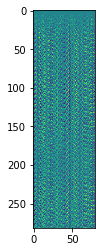

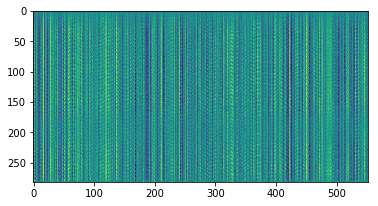

W0807 22:11:22.333698 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:11:24.692235 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:11:26.525652 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:11:28.952205 19780 optimizer_v2.py:979] Gradie

W0807 22:12:22.575414 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:12:23.940726 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:12:25.719130 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:12:27.089442 19780 optimizer_v2.py:979] Gradie

W0807 22:13:25.689120 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:13:27.632562 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:13:29.528994 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:13:30.973323 19780 optimizer_v2.py:979] Gradie

W0807 22:14:22.898744 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:14:25.769254 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:14:27.815456 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:14:30.974174 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.0003506064, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 225.7 sec
22h 15m 06s


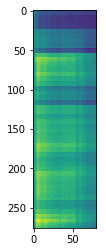

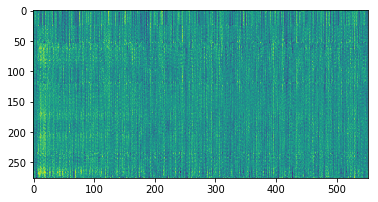

W0807 22:15:11.229535 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:15:12.618850 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:15:14.493276 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:15:16.322693 19780 optimizer_v2.py:979] Gradie

W0807 22:16:06.309075 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:16:07.671385 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:16:12.033378 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:16:13.892801 19780 optimizer_v2.py:979] Gradie

W0807 22:16:58.313915 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:17:00.248356 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:17:01.585660 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:17:03.557108 19780 optimizer_v2.py:979] Gradie

W0807 22:17:52.694303 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:17:57.353364 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:17:59.203786 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:18:00.608105 19780 optimizer_v2.py:979] Gradie

(16, 47)
tf.Tensor(0.0003134012, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 213.4 sec
22h 18m 39s


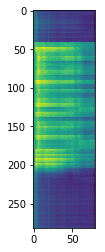

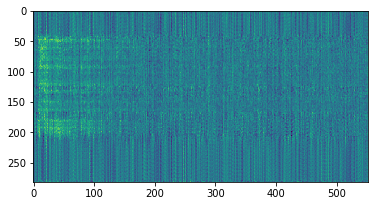

W0807 22:18:41.345381 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:18:44.228037 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:18:46.049452 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:18:47.460773 19780 optimizer_v2.py:979] Gradie

W0807 22:19:39.454502 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:19:41.311925 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:19:46.176033 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:19:47.502336 19780 optimizer_v2.py:979] Gradie

W0807 22:20:27.810372 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:20:29.229695 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:20:32.418421 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:20:34.330857 19780 optimizer_v2.py:979] Gradie

W0807 22:21:21.135513 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:21:22.470818 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:21:23.778115 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:21:26.269682 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.0002933422, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 207.9 sec
22h 22m 07s


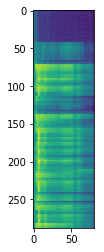

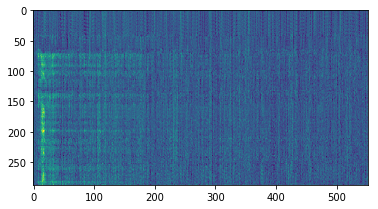

W0807 22:22:08.213233 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:22:11.261927 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:22:12.613234 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:22:14.537672 19780 optimizer_v2.py:979] Gradie

W0807 22:23:10.267361 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:23:12.113782 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:23:13.490096 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:23:16.433765 19780 optimizer_v2.py:979] Gradie

W0807 22:24:04.650744 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:24:06.534172 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:24:08.367590 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:24:10.919171 19780 optimizer_v2.py:979] Gradie

W0807 22:24:50.714232 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:24:52.527645 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:24:53.788932 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:24:55.672360 19780 optimizer_v2.py:979] Gradie

(16, 32)
tf.Tensor(0.00041644345, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 204.1 sec
22h 25m 31s


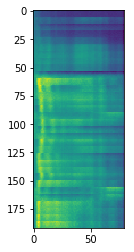

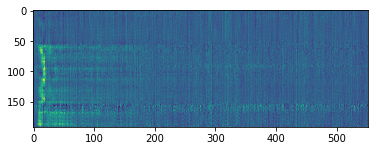

W0807 22:25:33.242915 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:25:34.525208 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:25:36.406635 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:25:37.669923 19780 optimizer_v2.py:979] Gradie

W0807 22:26:13.803151 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:26:15.639569 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:26:18.344184 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:26:19.697493 19780 optimizer_v2.py:979] Gradie

W0807 22:27:00.222719 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:27:01.541020 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:27:03.441452 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:27:06.241090 19780 optimizer_v2.py:979] Gradie

W0807 22:27:48.903803 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:27:49.905032 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:27:51.972502 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:27:53.279799 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00028307587, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 174.4 sec
22h 28m 25s


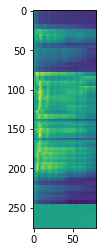

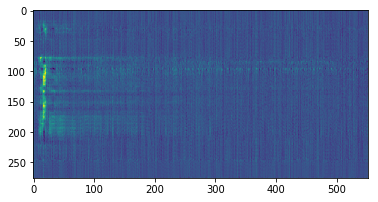

W0807 22:28:28.399796 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:28:29.758105 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:28:31.561516 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:28:33.510960 19780 optimizer_v2.py:979] Gradie

W0807 22:29:13.439051 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:29:14.765353 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:29:16.704794 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:29:18.029096 19780 optimizer_v2.py:979] Gradie

W0807 22:30:02.719272 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:30:04.521682 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:30:05.914999 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:30:07.715409 19780 optimizer_v2.py:979] Gradie

W0807 22:30:54.176988 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:30:56.040412 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:30:57.344709 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:30:59.197132 19780 optimizer_v2.py:979] Gradie

(16, 16)
tf.Tensor(0.0008161222, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 185.7 sec
22h 31m 31s


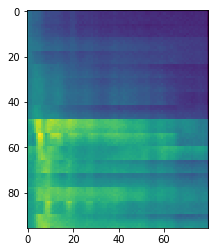

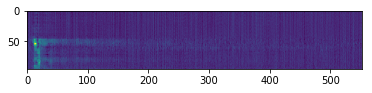

W0807 22:31:33.482937 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:31:34.787234 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:31:36.557637 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:31:39.184235 19780 optimizer_v2.py:979] Gradie

W0807 22:32:22.142892 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:32:23.625228 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:32:24.537437 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:32:26.444871 19780 optimizer_v2.py:979] Gradie

W0807 22:33:08.122138 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:33:09.973558 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:33:12.421116 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:33:13.803430 19780 optimizer_v2.py:979] Gradie

W0807 22:33:54.687571 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:33:55.513758 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:33:57.415191 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:33:58.735491 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.0002746734, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 180.4 sec
22h 34m 31s


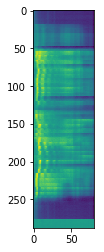

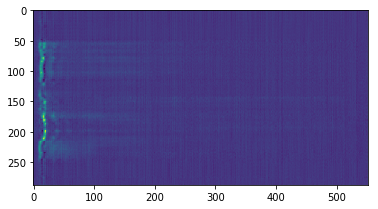

W0807 22:34:33.448395 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:34:35.352830 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:34:39.589794 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:34:40.900093 19780 optimizer_v2.py:979] Gradie

W0807 22:35:27.575720 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:35:29.454148 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:35:30.798454 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:35:32.730894 19780 optimizer_v2.py:979] Gradie

W0807 22:36:13.520180 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:36:14.882491 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:36:17.468079 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:36:19.299497 19780 optimizer_v2.py:979] Gradie

In [19]:
tacotron = Tacotron()

# Started hour
print(time.strftime("%Hh %Mm %Ss"))

start = time.time()

for i, (mel, linear, texts) in enumerate(tqdm((dataset))):
    
    loss, spec, mel = tacotron.train(mel, linear, texts)
    
    if i % 100 == 0:
        print(texts.shape)    
        print(loss)
        print('Time taken for 100 * 16 samples: {:.1f} sec'.format(time.time() - start))
        print(time.strftime("%Hh %Mm %Ss"))
        start = time.time()
        
        plt.figure()
        plt.imshow(spec[0])
        plt.show()
        
        plt.figure()
        plt.imshow(mel[0])
        plt.show()
        
        print('')
        

22h 40m 38s


W0807 22:40:40.999082 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00030706462, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.9 sec
22h 40m 41s


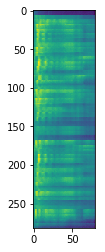

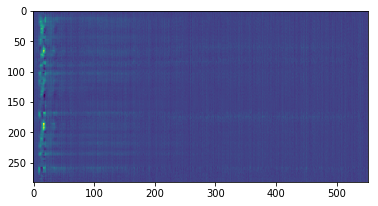

W0807 22:40:42.624452 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:40:44.423861 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:40:45.751164 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:40:47.532570 19780 optimizer_v2.py:979] Gradie

W0807 22:41:30.564367 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:41:31.945682 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:41:33.789102 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:41:35.090398 19780 optimizer_v2.py:979] Gradie

W0807 22:42:16.817899 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:42:18.731334 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:42:20.770799 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:42:22.086098 19780 optimizer_v2.py:979] Gradie

W0807 22:43:08.624694 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:43:11.378321 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:43:13.232743 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:43:16.115400 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00027127677, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 187.2 sec
22h 43m 48s


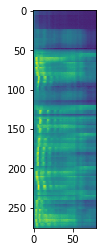

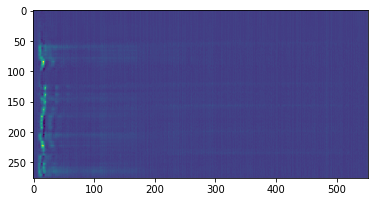

W0807 22:43:51.128372 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:43:52.410665 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:43:54.293092 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:43:56.195525 19780 optimizer_v2.py:979] Gradie

W0807 22:44:38.804227 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:44:40.166538 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:44:43.108206 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:44:44.894613 19780 optimizer_v2.py:979] Gradie

W0807 22:45:22.294130 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:45:24.058531 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:45:25.345825 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:45:27.200246 19780 optimizer_v2.py:979] Gradie

W0807 22:46:09.573894 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:46:12.751617 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:46:14.531023 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:46:15.844322 19780 optimizer_v2.py:979] Gradie

(16, 47)
tf.Tensor(0.000273719, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.0 sec
22h 46m 50s


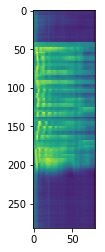

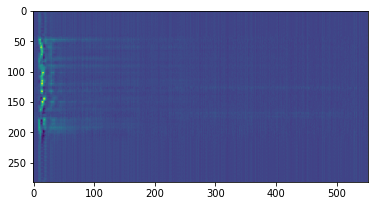

W0807 22:46:52.255612 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:46:55.100260 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:46:56.870663 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:46:58.229973 19780 optimizer_v2.py:979] Gradie

W0807 22:47:42.564067 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:47:44.324468 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:47:47.811261 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:47:49.080551 19780 optimizer_v2.py:979] Gradie

W0807 22:48:27.601321 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:48:28.954629 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:48:32.083343 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:48:33.869748 19780 optimizer_v2.py:979] Gradie

W0807 22:49:17.963788 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:49:19.271086 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:49:20.586386 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:49:23.085954 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.0002614305, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 191.2 sec
22h 50m 01s


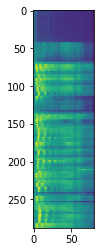

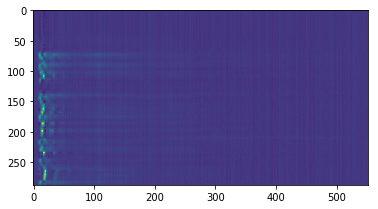

W0807 22:50:02.541939 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:50:05.470604 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:50:06.796906 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:50:08.702341 19780 optimizer_v2.py:979] Gradie

W0807 22:50:59.066809 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:51:00.878221 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:51:02.263535 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:51:05.250217 19780 optimizer_v2.py:979] Gradie

W0807 22:51:50.469513 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:51:52.271923 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:51:54.126344 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:51:56.666924 19780 optimizer_v2.py:979] Gradie

W0807 22:52:36.816064 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:52:38.654484 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:52:40.004790 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:52:41.919225 19780 optimizer_v2.py:979] Gradie

(16, 32)
tf.Tensor(0.00038275612, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 195.0 sec
22h 53m 16s


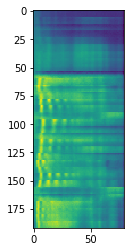

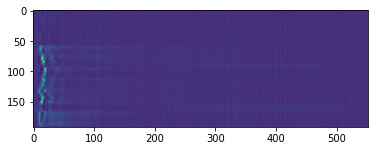

W0807 22:53:18.400532 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:53:19.790849 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:53:21.603262 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:53:22.970573 19780 optimizer_v2.py:979] Gradie

W0807 22:53:57.296389 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:53:59.104800 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:54:01.810416 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:54:03.199733 19780 optimizer_v2.py:979] Gradie

W0807 22:54:43.561922 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:54:44.877224 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:54:46.751649 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:54:49.347240 19780 optimizer_v2.py:979] Gradie

W0807 22:55:29.617409 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:55:30.428594 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:55:32.298019 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:55:33.609318 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00026163307, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 167.8 sec
22h 56m 04s


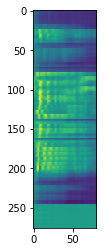

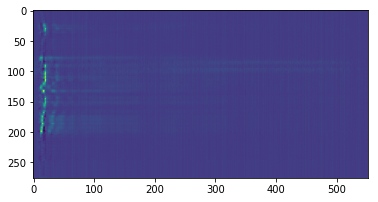

W0807 22:56:06.937906 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:56:08.292215 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:56:10.070619 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:56:11.956049 19780 optimizer_v2.py:979] Gradie

W0807 22:56:50.891914 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:56:52.215215 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:56:54.117648 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:56:55.434948 19780 optimizer_v2.py:979] Gradie

W0807 22:57:36.228236 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:57:38.060653 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:57:39.449970 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:57:41.283388 19780 optimizer_v2.py:979] Gradie

W0807 22:58:23.862082 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:58:25.679497 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:58:26.985793 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:58:28.811209 19780 optimizer_v2.py:979] Gradie

(16, 16)
tf.Tensor(0.00076897437, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 176.5 sec
22h 59m 00s


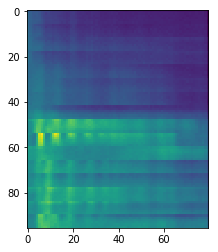

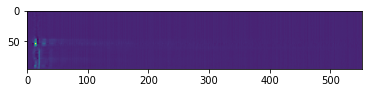

W0807 22:59:02.852960 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:59:04.170259 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:59:05.955666 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:59:08.524252 19780 optimizer_v2.py:979] Gradie

W0807 22:59:49.904673 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:59:51.266982 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:59:52.078168 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 22:59:53.847570 19780 optimizer_v2.py:979] Gradie

W0807 23:00:31.134061 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:00:32.933469 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:00:35.346019 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:00:36.706329 19780 optimizer_v2.py:979] Gradie

W0807 23:01:16.527395 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:01:17.353584 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:01:19.191002 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:01:20.517303 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00025870174, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 172.1 sec
23h 01m 53s


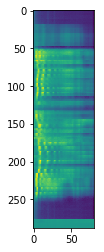

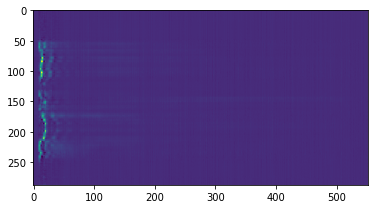

W0807 23:01:54.421024 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:01:56.301452 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:01:59.270127 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:02:00.585428 19780 optimizer_v2.py:979] Gradie

W0807 23:02:43.207132 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:02:45.068555 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:02:46.356849 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:02:48.210270 19780 optimizer_v2.py:979] Gradie

W0807 23:03:28.531451 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:03:29.848751 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:03:32.604379 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:03:34.383783 19780 optimizer_v2.py:979] Gradie

W0807 23:04:04.352607 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00029555502, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.9 sec
23h 04m 04s


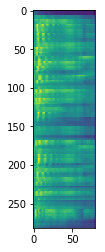

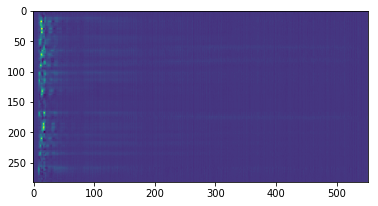

W0807 23:04:05.932968 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:04:07.835401 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:04:09.110690 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:04:10.882093 19780 optimizer_v2.py:979] Gradie

W0807 23:04:54.063926 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:04:55.459244 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:04:57.309665 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:04:58.612962 19780 optimizer_v2.py:979] Gradie

W0807 23:05:39.865355 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:05:41.775789 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:05:43.706230 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:05:44.991522 19780 optimizer_v2.py:979] Gradie

W0807 23:06:28.859509 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:06:31.576128 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:06:33.515569 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:06:36.397226 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00025764148, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 184.0 sec
23h 07m 08s


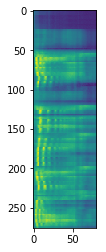

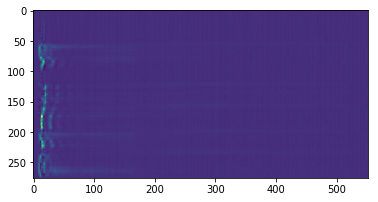

W0807 23:07:11.243159 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:07:12.529453 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:07:14.407881 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:07:16.227294 19780 optimizer_v2.py:979] Gradie

W0807 23:07:58.778984 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:08:00.094283 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:08:03.060957 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:08:04.935384 19780 optimizer_v2.py:979] Gradie

W0807 23:08:42.396914 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:08:44.101302 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:08:45.460613 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:08:47.325037 19780 optimizer_v2.py:979] Gradie

W0807 23:09:29.857720 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:09:33.045447 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:09:34.819850 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:09:36.148152 19780 optimizer_v2.py:979] Gradie

(16, 47)
tf.Tensor(0.00026234813, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.2 sec
23h 10m 10s


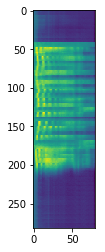

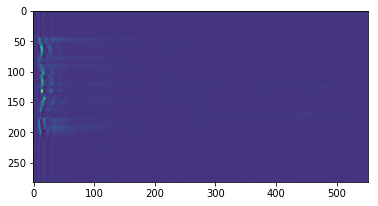

W0807 23:10:12.607454 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:10:15.455102 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:10:17.232507 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:10:18.627825 19780 optimizer_v2.py:979] Gradie

W0807 23:11:03.216978 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:11:04.964375 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:11:08.473173 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:11:09.735462 19780 optimizer_v2.py:979] Gradie

W0807 23:11:48.106198 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:11:49.457506 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:11:52.547209 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:11:54.325613 19780 optimizer_v2.py:979] Gradie

W0807 23:12:38.417653 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:12:39.694943 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:12:40.968234 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:12:43.420792 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00025251397, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 190.5 sec
23h 13m 21s


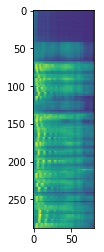

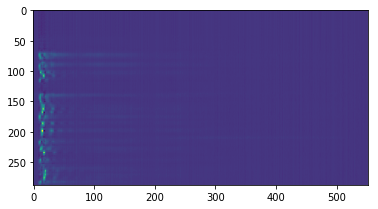

W0807 23:13:22.116603 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:13:25.004260 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:13:26.313559 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:13:28.168980 19780 optimizer_v2.py:979] Gradie

W0807 23:14:17.354180 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:14:19.189597 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:14:20.463888 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:14:23.344543 19780 optimizer_v2.py:979] Gradie

W0807 23:15:07.656633 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:15:09.507053 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:15:11.263454 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:15:13.793029 19780 optimizer_v2.py:979] Gradie

W0807 23:15:53.255014 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:15:55.091433 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:15:56.335716 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:15:58.217144 19780 optimizer_v2.py:979] Gradie

(16, 32)
tf.Tensor(0.0003694325, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 191.1 sec
23h 16m 32s


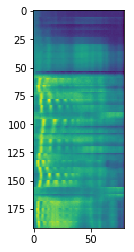

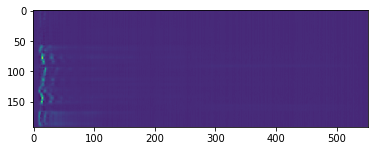

W0807 23:16:34.167330 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:16:35.487631 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:16:37.256033 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:16:38.595338 19780 optimizer_v2.py:979] Gradie

W0807 23:17:12.593079 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:17:14.372484 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:17:17.054095 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:17:18.432409 19780 optimizer_v2.py:979] Gradie

W0807 23:17:57.955407 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:17:59.309716 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:18:01.081120 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:18:03.602693 19780 optimizer_v2.py:979] Gradie

W0807 23:18:43.154699 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:18:43.971885 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:18:45.809303 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:18:47.096596 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00025354995, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 165.1 sec
23h 19m 17s


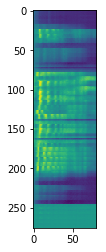

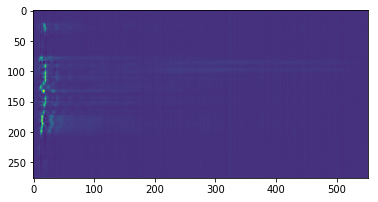

W0807 23:19:19.855054 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:19:21.230369 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:19:22.967763 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:19:24.861194 19780 optimizer_v2.py:979] Gradie

W0807 23:20:02.843843 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:20:04.130136 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:20:05.974555 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:20:07.289855 19780 optimizer_v2.py:979] Gradie

W0807 23:20:47.364979 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:20:49.163389 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:20:50.456684 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:20:52.277098 19780 optimizer_v2.py:979] Gradie

W0807 23:21:34.014601 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:21:35.811011 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:21:37.097303 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:21:38.907715 19780 optimizer_v2.py:979] Gradie

(16, 16)
tf.Tensor(0.00074142334, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 172.9 sec
23h 22m 10s


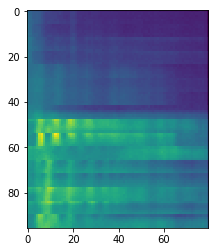

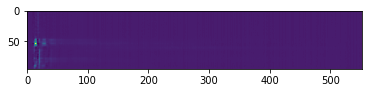

W0807 23:22:12.278314 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:22:13.570607 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:22:15.322007 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:22:17.840580 19780 optimizer_v2.py:979] Gradie

W0807 23:22:58.647871 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:22:59.938164 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:23:00.761353 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:23:02.620776 19780 optimizer_v2.py:979] Gradie

W0807 23:23:39.367143 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:23:41.117541 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:23:43.460074 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:23:44.789377 19780 optimizer_v2.py:979] Gradie

W0807 23:24:24.040313 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:24:24.844497 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:24:26.656910 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:24:27.978211 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00024838472, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 169.5 sec
23h 24m 59s


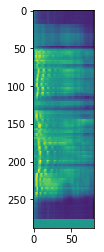

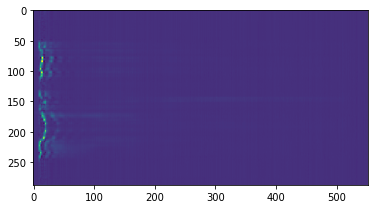

W0807 23:25:01.282794 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:25:03.140216 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:25:06.072884 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:25:07.365179 19780 optimizer_v2.py:979] Gradie

W0807 23:25:49.151692 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:25:50.955103 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:25:52.220392 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:25:53.988793 19780 optimizer_v2.py:979] Gradie

W0807 23:26:33.009678 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:26:34.340981 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:26:36.942574 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:26:38.677970 19780 optimizer_v2.py:979] Gradie

W0807 23:27:07.506533 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00029317322, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.4 sec
23h 27m 07s


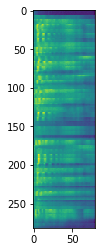

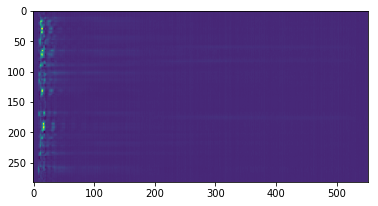

W0807 23:27:09.135904 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:27:11.171368 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:27:12.547681 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:27:14.513129 19780 optimizer_v2.py:979] Gradie

W0807 23:27:57.557930 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:27:58.921240 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:28:00.654633 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:28:02.003942 19780 optimizer_v2.py:979] Gradie

W0807 23:28:42.709209 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:28:44.588638 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:28:46.388047 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:28:47.742356 19780 optimizer_v2.py:979] Gradie

W0807 23:29:31.296271 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:29:34.003888 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:29:35.842307 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:29:38.724963 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00025045857, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 183.0 sec
23h 30m 10s


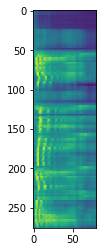

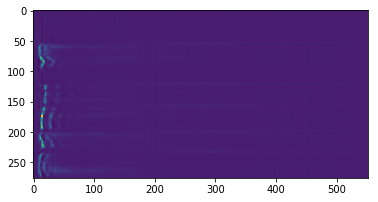

W0807 23:30:13.359849 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:30:14.650143 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:30:16.476558 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:30:18.268967 19780 optimizer_v2.py:979] Gradie

W0807 23:31:00.670622 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:31:01.972918 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:31:04.922589 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:31:06.782012 19780 optimizer_v2.py:979] Gradie

W0807 23:31:44.061501 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:31:45.846907 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:31:47.120198 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:31:48.967617 19780 optimizer_v2.py:979] Gradie

W0807 23:32:31.343266 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:32:34.551996 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:32:36.411420 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:32:37.654704 19780 optimizer_v2.py:979] Gradie

(16, 47)
tf.Tensor(0.00025644232, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 181.6 sec
23h 33m 12s


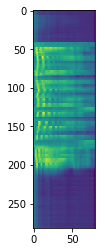

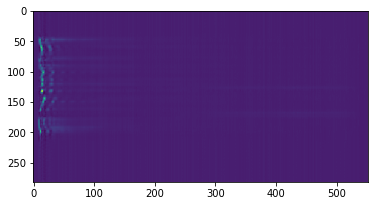

W0807 23:33:14.061993 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:33:16.904640 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:33:18.738058 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:33:20.082363 19780 optimizer_v2.py:979] Gradie

W0807 23:34:04.526484 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:34:06.302887 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:34:09.777678 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:34:11.058970 19780 optimizer_v2.py:979] Gradie

W0807 23:34:49.436708 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:34:50.787016 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:34:53.872718 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:34:55.654124 19780 optimizer_v2.py:979] Gradie

W0807 23:35:39.335069 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:35:40.616362 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:35:41.884650 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:35:44.298199 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00024493271, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 189.4 sec
23h 36m 21s


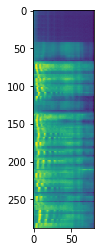

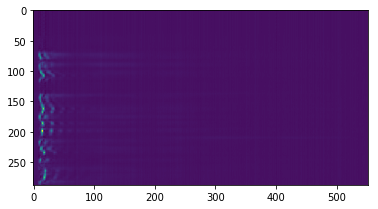

W0807 23:36:22.556911 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:36:25.460572 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:36:26.751866 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:36:28.592284 19780 optimizer_v2.py:979] Gradie

W0807 23:37:17.725471 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:37:19.499876 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:37:20.839181 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:37:23.705833 19780 optimizer_v2.py:979] Gradie

W0807 23:38:07.783869 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:38:09.565275 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:38:11.373686 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:38:13.890259 19780 optimizer_v2.py:979] Gradie

W0807 23:38:53.122192 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:38:54.895596 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:38:56.200893 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:38:58.057316 19780 optimizer_v2.py:979] Gradie

(16, 32)
tf.Tensor(0.0003583524, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 190.2 sec
23h 39m 31s


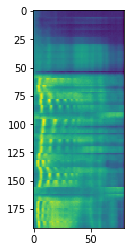

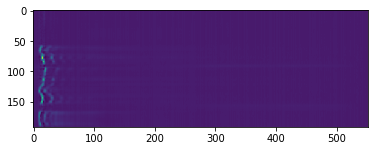

W0807 23:39:33.647419 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:39:34.993726 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:39:36.759128 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:39:38.089431 19780 optimizer_v2.py:979] Gradie

W0807 23:40:11.637069 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:40:13.420475 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:40:16.076080 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:40:17.420386 19780 optimizer_v2.py:979] Gradie

W0807 23:40:56.625313 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:40:57.887601 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:40:59.734020 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:41:02.251593 19780 optimizer_v2.py:979] Gradie

W0807 23:41:41.534538 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:41:42.329719 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:41:44.139131 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:41:45.409420 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00024700255, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 163.5 sec
23h 42m 15s


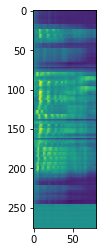

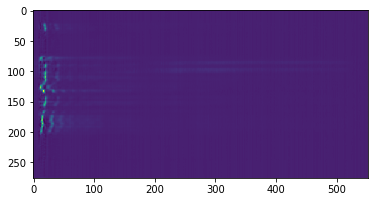

W0807 23:42:17.903818 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:42:19.231121 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:42:20.973517 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:42:22.820937 19780 optimizer_v2.py:979] Gradie

W0807 23:43:00.763578 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:43:02.043869 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:43:03.874286 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:43:05.165580 19780 optimizer_v2.py:979] Gradie

W0807 23:43:44.979645 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:43:46.766051 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:43:48.054345 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:43:49.895764 19780 optimizer_v2.py:979] Gradie

W0807 23:44:31.322196 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:44:33.160615 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:44:34.432904 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:44:36.206308 19780 optimizer_v2.py:979] Gradie

(16, 16)
tf.Tensor(0.00072497636, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 172.0 sec
23h 45m 07s


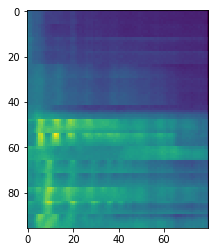

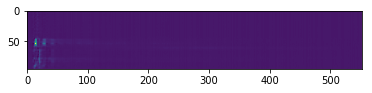

W0807 23:45:09.373860 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:45:10.662153 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:45:12.405550 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:45:14.900118 19780 optimizer_v2.py:979] Gradie

W0807 23:45:55.405340 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:45:56.753648 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:45:57.546828 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:45:59.294226 19780 optimizer_v2.py:979] Gradie

W0807 23:46:35.985580 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:46:37.760984 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:46:40.103518 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:46:41.422819 19780 optimizer_v2.py:979] Gradie

W0807 23:47:20.351681 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:47:21.158865 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:47:22.898262 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:47:24.252570 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.0002420095, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 168.7 sec
23h 47m 56s


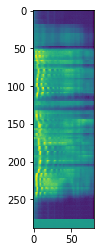

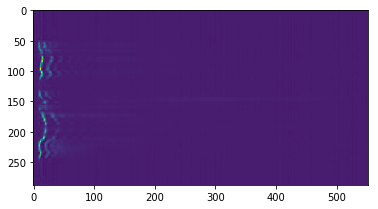

W0807 23:47:57.497139 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:47:59.350562 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:48:02.284230 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:48:03.566522 19780 optimizer_v2.py:979] Gradie

W0807 23:48:45.347034 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:48:47.147444 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:48:48.411732 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:48:50.177133 19780 optimizer_v2.py:979] Gradie

W0807 23:49:29.297041 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:49:30.641347 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:49:33.162921 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:49:34.960331 19780 optimizer_v2.py:979] Gradie

W0807 23:50:04.182984 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00029010544, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.7 sec
23h 50m 04s


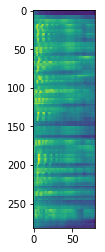

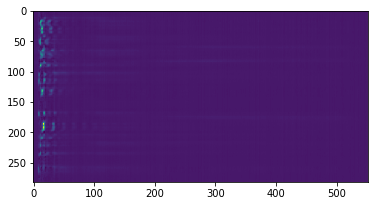

W0807 23:50:05.669323 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:50:07.503741 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:50:08.754025 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:50:10.565438 19780 optimizer_v2.py:979] Gradie

W0807 23:50:52.790050 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:50:54.147360 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:50:55.873754 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:50:57.208057 19780 optimizer_v2.py:979] Gradie

W0807 23:51:37.606256 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:51:39.473680 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:51:41.258087 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:51:42.613395 19780 optimizer_v2.py:979] Gradie

W0807 23:52:26.231327 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:52:29.027963 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:52:30.884387 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:52:33.805050 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00024802404, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 181.5 sec
23h 53m 05s


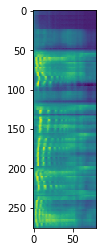

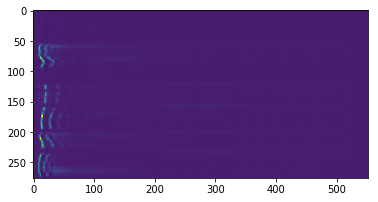

W0807 23:53:08.488948 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:53:09.851259 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:53:11.626662 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:53:13.499089 19780 optimizer_v2.py:979] Gradie

W0807 23:53:55.983762 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:53:57.272056 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:54:00.294743 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:54:02.113158 19780 optimizer_v2.py:979] Gradie

W0807 23:54:39.908763 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:54:41.623154 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:54:42.980463 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:54:44.766869 19780 optimizer_v2.py:979] Gradie

W0807 23:55:27.345564 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:55:30.524287 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:55:32.293691 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:55:33.545977 19780 optimizer_v2.py:979] Gradie

(16, 47)
tf.Tensor(0.00025029626, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.7 sec
23h 56m 08s


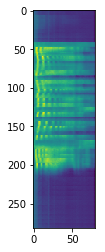

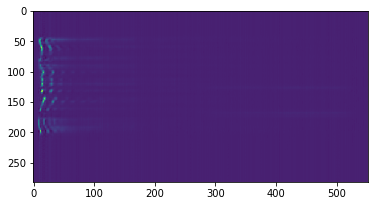

W0807 23:56:10.403367 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:56:13.234011 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:56:15.090435 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:56:16.398733 19780 optimizer_v2.py:979] Gradie

W0807 23:57:01.388976 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:57:03.241398 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:57:06.685182 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:57:07.959473 19780 optimizer_v2.py:979] Gradie

W0807 23:57:46.344213 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:57:47.693520 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:57:50.791224 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:57:52.576631 19780 optimizer_v2.py:979] Gradie

W0807 23:58:36.435617 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:58:37.703907 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:58:38.969194 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:58:41.386744 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00023649746, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 190.3 sec
23h 59m 18s


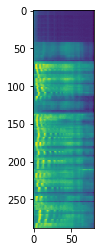

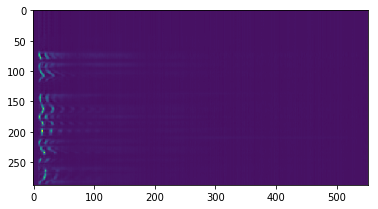

W0807 23:59:19.732476 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:59:22.614131 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:59:23.907426 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0807 23:59:25.751847 19780 optimizer_v2.py:979] Gradie

W0808 00:00:14.719994 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:00:16.511403 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:00:17.869713 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:00:20.750368 19780 optimizer_v2.py:979] Gradie

W0808 00:01:04.845408 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:01:06.627813 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:01:08.452229 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:01:10.945797 19780 optimizer_v2.py:979] Gradie

W0808 00:01:50.184731 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:01:51.957134 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:01:53.265433 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:01:55.125857 19780 optimizer_v2.py:979] Gradie

(16, 32)
tf.Tensor(0.00034999277, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 190.3 sec
00h 02m 29s


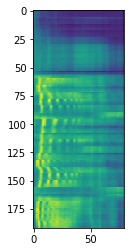

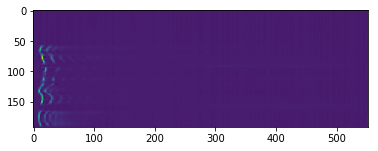

W0808 00:02:30.838987 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:02:32.210300 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:02:33.985703 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:02:35.328010 19780 optimizer_v2.py:979] Gradie

W0808 00:03:09.016681 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:03:10.789083 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:03:13.455691 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:03:14.821002 19780 optimizer_v2.py:979] Gradie

W0808 00:03:54.095944 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:03:55.440250 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:03:57.283669 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:03:59.727226 19780 optimizer_v2.py:979] Gradie

W0808 00:04:39.054181 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:04:39.932381 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:04:41.670776 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:04:43.014082 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00024337262, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 164.0 sec
00h 05m 13s


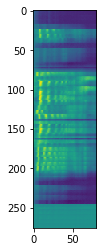

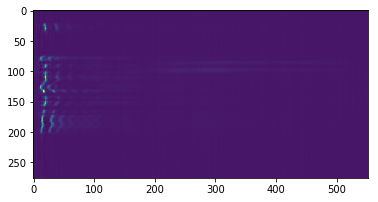

W0808 00:05:15.518483 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:05:16.786772 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:05:18.586181 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:05:20.361585 19780 optimizer_v2.py:979] Gradie

W0808 00:05:58.301224 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:05:59.576514 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:06:01.419934 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:06:02.706227 19780 optimizer_v2.py:979] Gradie

W0808 00:06:42.519292 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:06:44.298697 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:06:45.663008 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:06:47.426409 19780 optimizer_v2.py:979] Gradie

W0808 00:07:28.973869 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:07:30.778279 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:07:32.054571 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:07:33.834976 19780 optimizer_v2.py:979] Gradie

(16, 16)
tf.Tensor(0.00071518443, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 172.1 sec
00h 08m 05s


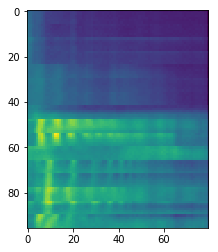

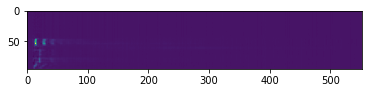

W0808 00:08:07.008528 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:08:08.375841 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:08:10.052222 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:08:12.527785 19780 optimizer_v2.py:979] Gradie

W0808 00:08:53.036009 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:08:54.307298 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:08:55.091477 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:08:56.838874 19780 optimizer_v2.py:979] Gradie

W0808 00:09:33.430207 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:09:35.186605 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:09:37.522137 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:09:38.837437 19780 optimizer_v2.py:979] Gradie

W0808 00:10:17.900331 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:10:18.696514 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:10:20.507925 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:10:21.788217 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00023597192, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 168.6 sec
00h 10m 53s


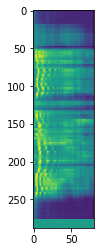

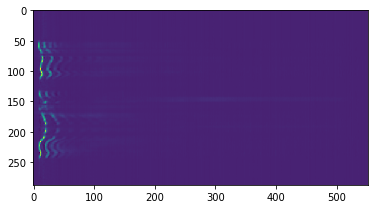

W0808 00:10:55.083798 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:10:56.948222 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:10:59.886891 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:11:01.179186 19780 optimizer_v2.py:979] Gradie

W0808 00:11:42.810664 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:11:44.630079 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:11:45.893366 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:11:47.666769 19780 optimizer_v2.py:979] Gradie

W0808 00:12:26.922708 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:12:28.185996 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:12:30.768585 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:12:32.612003 19780 optimizer_v2.py:979] Gradie

W0808 00:13:01.916675 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00029233872, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.7 sec
00h 13m 02s


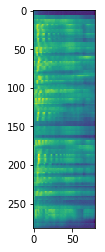

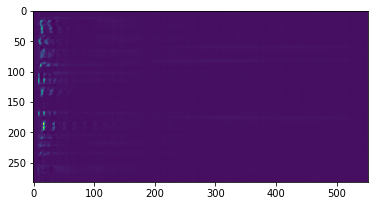

W0808 00:13:03.495035 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:13:05.273439 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:13:06.580738 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:13:08.298128 19780 optimizer_v2.py:979] Gradie

W0808 00:13:50.525743 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:13:51.878051 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:13:53.715470 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:13:54.989760 19780 optimizer_v2.py:979] Gradie

W0808 00:14:35.480979 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:14:37.342402 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:14:39.205827 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:14:40.481117 19780 optimizer_v2.py:979] Gradie

W0808 00:15:24.305095 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:15:27.013712 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:15:28.887139 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:15:31.759793 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00024475474, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 181.7 sec
00h 16m 03s


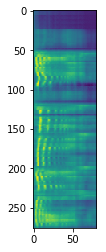

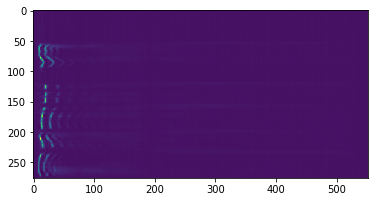

W0808 00:16:06.498702 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:16:07.862014 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:16:09.627415 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:16:11.487838 19780 optimizer_v2.py:979] Gradie

W0808 00:16:54.020523 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:16:55.317818 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:16:58.349508 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:17:00.125913 19780 optimizer_v2.py:979] Gradie

W0808 00:17:37.644455 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:17:39.350843 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:17:40.710153 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:17:42.486558 19780 optimizer_v2.py:979] Gradie

W0808 00:18:25.121265 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:18:28.317993 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:18:30.099399 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:18:31.413698 19780 optimizer_v2.py:979] Gradie

(16, 47)
tf.Tensor(0.0002460721, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.4 sec
00h 19m 06s


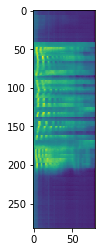

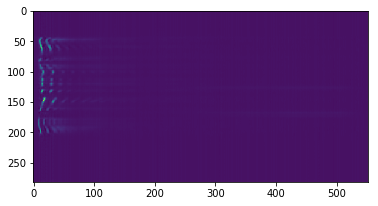

W0808 00:19:08.033035 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:19:10.789663 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:19:12.640084 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:19:13.996393 19780 optimizer_v2.py:979] Gradie

W0808 00:19:58.399503 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:20:00.237921 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:20:03.671703 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:20:04.933991 19780 optimizer_v2.py:979] Gradie

W0808 00:20:43.386746 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:20:44.749057 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:20:47.846761 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:20:49.629167 19780 optimizer_v2.py:979] Gradie

W0808 00:21:33.402134 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:21:34.689428 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:21:35.959717 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:21:38.375266 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00023220772, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 189.7 sec
00h 22m 15s


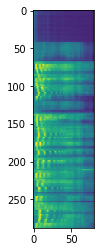

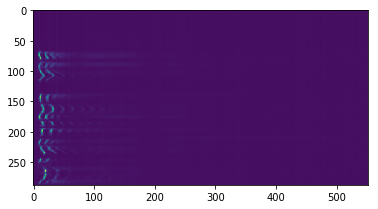

W0808 00:22:16.791014 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:22:19.673669 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:22:20.967965 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:22:22.820386 19780 optimizer_v2.py:979] Gradie

W0808 00:23:12.089603 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:23:13.924021 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:23:15.213316 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:23:18.069965 19780 optimizer_v2.py:979] Gradie

W0808 00:24:02.245024 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:24:04.092445 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:24:05.910858 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:24:08.365417 19780 optimizer_v2.py:979] Gradie

W0808 00:24:47.971435 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:24:49.757842 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:24:51.079143 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:24:52.860548 19780 optimizer_v2.py:979] Gradie

(16, 32)
tf.Tensor(0.00034164195, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 190.9 sec
00h 25m 26s


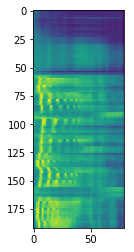

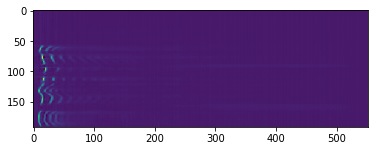

W0808 00:25:28.595684 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:25:29.964998 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:25:31.742401 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:25:33.068704 19780 optimizer_v2.py:979] Gradie

W0808 00:26:06.626344 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:26:08.399747 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:26:11.042349 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:26:12.395658 19780 optimizer_v2.py:979] Gradie

W0808 00:26:51.633591 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:26:52.917884 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:26:54.755302 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:26:57.285879 19780 optimizer_v2.py:979] Gradie

W0808 00:27:36.545818 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:27:37.339998 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:27:39.155411 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:27:40.515722 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00024037095, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 163.8 sec
00h 28m 10s


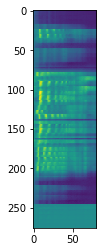

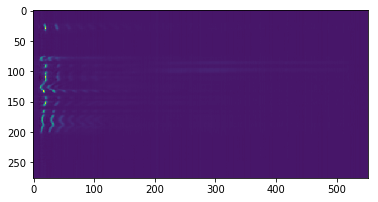

W0808 00:28:13.010119 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:28:14.346424 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:28:16.100823 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:28:17.958246 19780 optimizer_v2.py:979] Gradie

W0808 00:28:55.960899 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:28:57.259194 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:28:59.126619 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:29:00.410913 19780 optimizer_v2.py:979] Gradie

W0808 00:29:40.222976 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:29:42.008383 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:29:43.357691 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:29:45.120091 19780 optimizer_v2.py:979] Gradie

W0808 00:30:27.147173 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:30:28.955585 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:30:30.241878 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:30:32.060293 19780 optimizer_v2.py:979] Gradie

(16, 16)
tf.Tensor(0.0007015888, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 172.9 sec
00h 31m 03s


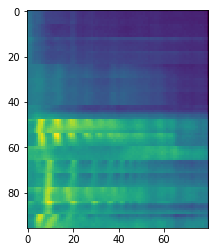

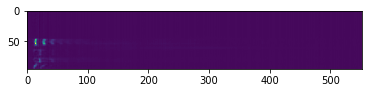

W0808 00:31:05.396883 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:31:06.686177 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:31:08.445577 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:31:10.964151 19780 optimizer_v2.py:979] Gradie

W0808 00:31:51.509382 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:31:52.850688 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:31:53.646869 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:31:55.414272 19780 optimizer_v2.py:979] Gradie

W0808 00:32:32.090621 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:32:33.880030 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:32:36.221563 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:32:37.538863 19780 optimizer_v2.py:979] Gradie

W0808 00:33:16.797801 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:33:17.595984 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:33:19.415397 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:33:20.702690 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00023220306, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 169.2 sec
00h 33m 52s


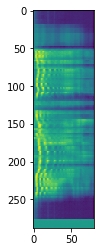

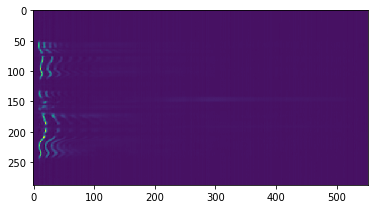

W0808 00:33:54.023277 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:33:55.882700 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:33:58.804365 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:34:00.079656 19780 optimizer_v2.py:979] Gradie

W0808 00:34:41.818159 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:34:43.639574 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:34:44.908863 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:34:46.679266 19780 optimizer_v2.py:979] Gradie

W0808 00:35:25.898196 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:35:27.161484 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:35:29.761075 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:35:31.563485 19780 optimizer_v2.py:979] Gradie

W0808 00:36:00.771135 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00028546812, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.7 sec
00h 36m 00s


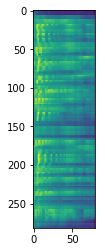

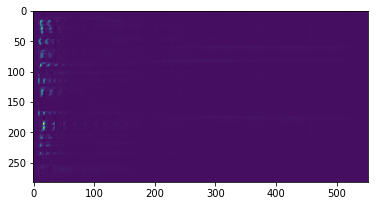

W0808 00:36:02.314488 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:36:04.086890 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:36:05.397189 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:36:07.105577 19780 optimizer_v2.py:979] Gradie

W0808 00:36:49.151151 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:36:50.510461 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:36:52.312872 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:36:53.585161 19780 optimizer_v2.py:979] Gradie

W0808 00:37:33.954353 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:37:35.796773 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:37:37.660196 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:37:38.936487 19780 optimizer_v2.py:979] Gradie

W0808 00:38:22.730458 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:38:25.445076 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:38:27.328505 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:38:30.232165 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.0002417836, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 181.5 sec
00h 39m 02s


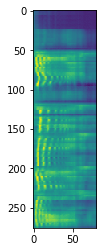

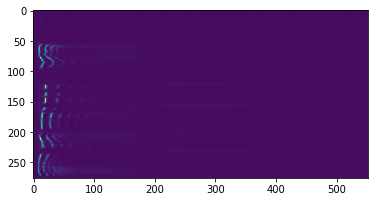

W0808 00:39:05.094104 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:39:06.451413 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:39:08.228817 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:39:10.088241 19780 optimizer_v2.py:979] Gradie

W0808 00:39:52.458888 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:39:53.752182 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:39:56.790874 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:39:58.554275 19780 optimizer_v2.py:979] Gradie

W0808 00:40:35.956792 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:40:37.661181 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:40:39.017489 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:40:40.815899 19780 optimizer_v2.py:979] Gradie

W0808 00:41:23.236557 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:41:26.412280 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:41:28.194685 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:41:29.500984 19780 optimizer_v2.py:979] Gradie

(16, 47)
tf.Tensor(0.0002432668, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 181.6 sec
00h 42m 03s


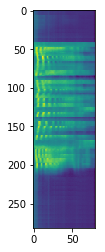

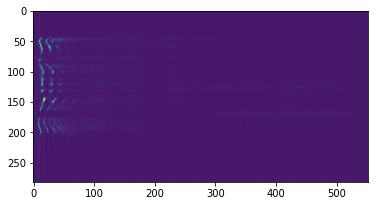

W0808 00:42:05.878266 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:42:08.658899 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:42:10.505319 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:42:11.876632 19780 optimizer_v2.py:979] Gradie

W0808 00:42:56.331753 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:42:58.180175 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:43:01.629960 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:43:02.892248 19780 optimizer_v2.py:979] Gradie

W0808 00:43:41.212973 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:43:42.488263 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:43:45.658984 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:43:47.423386 19780 optimizer_v2.py:979] Gradie

W0808 00:44:31.194352 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:44:32.546660 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:44:33.815950 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:44:36.245502 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00022750777, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 189.8 sec
00h 45m 13s


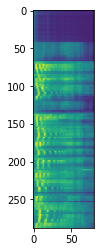

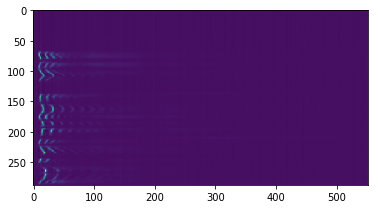

W0808 00:45:14.648247 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:45:17.543905 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:45:18.832199 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:45:20.678619 19780 optimizer_v2.py:979] Gradie

W0808 00:46:09.934834 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:46:11.707238 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:46:13.066548 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:46:15.939201 19780 optimizer_v2.py:979] Gradie

W0808 00:47:00.139265 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:47:01.925672 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:47:03.748087 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:47:06.277662 19780 optimizer_v2.py:979] Gradie

W0808 00:47:45.572609 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:47:47.347014 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:47:48.653311 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:47:50.507733 19780 optimizer_v2.py:979] Gradie

(16, 32)
tf.Tensor(0.00033659188, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 190.7 sec
00h 48m 24s


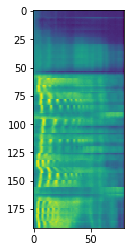

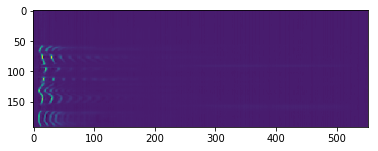

W0808 00:48:26.186856 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:48:27.548168 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:48:29.321571 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:48:30.680881 19780 optimizer_v2.py:979] Gradie

W0808 00:49:04.358549 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:49:06.132953 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:49:08.805562 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:49:10.178874 19780 optimizer_v2.py:979] Gradie

W0808 00:49:49.459818 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:49:50.804123 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:49:52.650543 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:49:55.107103 19780 optimizer_v2.py:979] Gradie

W0808 00:50:34.413053 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:50:35.293253 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:50:37.036649 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:50:38.377956 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.0002374052, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 164.0 sec
00h 51m 08s


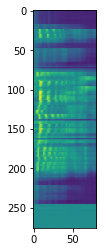

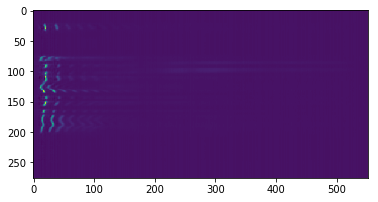

W0808 00:51:10.928367 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:51:12.186653 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:51:13.992064 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:51:15.850488 19780 optimizer_v2.py:979] Gradie

W0808 00:51:53.703105 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:51:54.989399 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:51:56.861825 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:51:58.147118 19780 optimizer_v2.py:979] Gradie

W0808 00:52:38.059205 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:52:39.903625 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:52:41.261934 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:52:43.024335 19780 optimizer_v2.py:979] Gradie

W0808 00:53:24.748836 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:53:26.532242 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:53:27.898553 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:53:29.616944 19780 optimizer_v2.py:979] Gradie

(16, 16)
tf.Tensor(0.0006942179, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 172.5 sec
00h 54m 01s


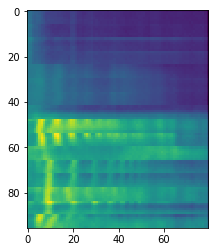

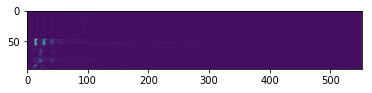

W0808 00:54:02.882518 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:54:04.167811 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:54:05.927212 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:54:08.424780 19780 optimizer_v2.py:979] Gradie

W0808 00:54:48.944006 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:54:50.219296 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:54:51.084494 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:54:52.769878 19780 optimizer_v2.py:979] Gradie

W0808 00:55:29.400217 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:55:31.235635 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:55:33.582170 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:55:34.833455 19780 optimizer_v2.py:979] Gradie

W0808 00:56:14.021377 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:56:14.811558 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:56:16.617968 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:56:17.911263 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00022910403, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 168.9 sec
00h 56m 49s


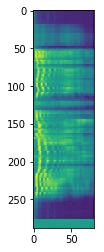

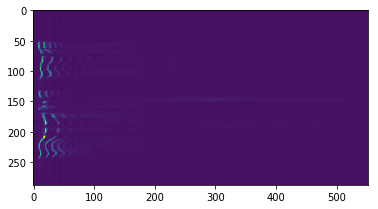

W0808 00:56:51.348876 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:56:53.139284 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:56:56.065949 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:56:57.411256 19780 optimizer_v2.py:979] Gradie

W0808 00:57:39.241780 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:57:41.068196 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:57:42.343486 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:57:44.123892 19780 optimizer_v2.py:979] Gradie

W0808 00:58:23.430842 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:58:24.770147 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:58:27.303723 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:58:29.112135 19780 optimizer_v2.py:979] Gradie

W0808 00:58:58.417808 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00028235276, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.8 sec
00h 58m 58s


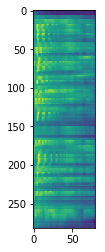

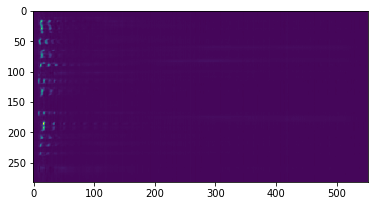

W0808 00:58:59.901146 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:59:01.766570 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:59:03.004852 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:59:04.792258 19780 optimizer_v2.py:979] Gradie

W0808 00:59:47.068885 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:59:48.374182 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:59:50.189595 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 00:59:51.539903 19780 optimizer_v2.py:979] Gradie

W0808 01:00:31.886090 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:00:33.815528 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:00:35.612937 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:00:36.957243 19780 optimizer_v2.py:979] Gradie

W0808 01:01:20.572174 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:01:23.375812 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:01:25.241238 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:01:28.134896 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00023724449, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 181.4 sec
01h 01m 59s


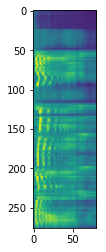

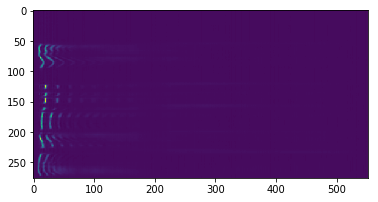

W0808 01:02:02.687763 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:02:04.046073 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:02:05.830479 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:02:07.680900 19780 optimizer_v2.py:979] Gradie

W0808 01:02:50.245591 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:02:51.541887 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:02:54.563574 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:02:56.370986 19780 optimizer_v2.py:979] Gradie

W0808 01:03:33.849520 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:03:35.564911 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:03:36.912217 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:03:38.692622 19780 optimizer_v2.py:979] Gradie

W0808 01:04:21.153290 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:04:24.344017 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:04:26.137425 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:04:27.459727 19780 optimizer_v2.py:979] Gradie

(16, 47)
tf.Tensor(0.00024076723, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.1 sec
01h 05m 02s


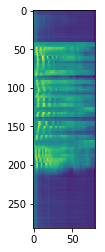

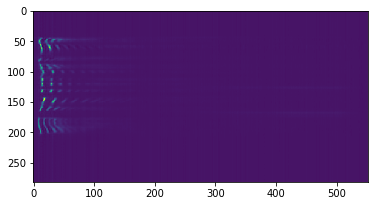

W0808 01:05:03.977041 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:05:06.753673 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:05:08.588090 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:05:09.947401 19780 optimizer_v2.py:979] Gradie

W0808 01:05:54.410523 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:05:56.260946 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:05:59.667721 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:06:00.953013 19780 optimizer_v2.py:979] Gradie

W0808 01:06:39.427774 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:06:40.702064 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:06:43.809771 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:06:45.665193 19780 optimizer_v2.py:979] Gradie

W0808 01:07:29.361142 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:07:30.645436 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:07:31.995743 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:07:34.435298 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00022616843, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 189.7 sec
01h 08m 11s


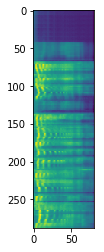

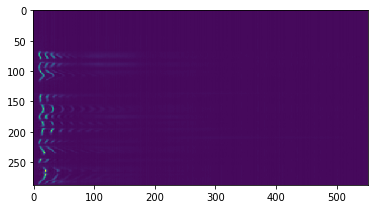

W0808 01:08:12.757024 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:08:15.672687 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:08:16.955980 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:08:18.735385 19780 optimizer_v2.py:979] Gradie

W0808 01:09:07.970595 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:09:09.744998 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:09:11.084304 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:09:13.940954 19780 optimizer_v2.py:979] Gradie

W0808 01:09:57.962978 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:09:59.804396 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:10:01.619810 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:10:04.077369 19780 optimizer_v2.py:979] Gradie

W0808 01:10:43.598369 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:10:45.444788 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:10:46.769090 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:10:48.567500 19780 optimizer_v2.py:979] Gradie

(16, 32)
tf.Tensor(0.0003329747, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 190.6 sec
01h 11m 22s


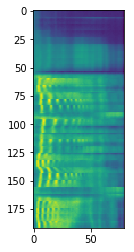

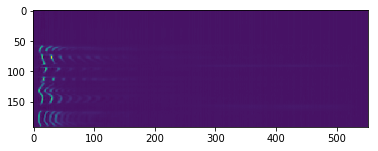

W0808 01:11:24.168605 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:11:25.512912 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:11:27.272312 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:11:28.623619 19780 optimizer_v2.py:979] Gradie

W0808 01:12:02.215268 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:12:03.980669 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:12:06.626272 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:12:07.989583 19780 optimizer_v2.py:979] Gradie

W0808 01:12:47.269526 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:12:48.549818 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:12:50.394237 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:12:52.926814 19780 optimizer_v2.py:979] Gradie

W0808 01:13:32.343790 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:13:33.138971 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:13:34.974388 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:13:36.352702 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00023541486, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 164.1 sec
01h 14m 06s


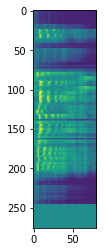

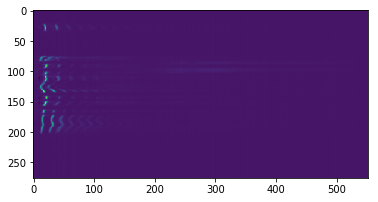

W0808 01:14:08.854102 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:14:10.183405 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:14:11.918800 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:14:13.781224 19780 optimizer_v2.py:979] Gradie

W0808 01:14:51.767873 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:14:53.052166 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:14:54.909589 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:14:56.212885 19780 optimizer_v2.py:979] Gradie

W0808 01:15:35.981940 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:15:37.782350 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:15:39.128657 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:15:40.899060 19780 optimizer_v2.py:979] Gradie

W0808 01:16:22.470525 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:16:24.251931 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:16:25.529222 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:16:27.343634 19780 optimizer_v2.py:979] Gradie

(16, 16)
tf.Tensor(0.0006836454, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 172.3 sec
01h 16m 58s


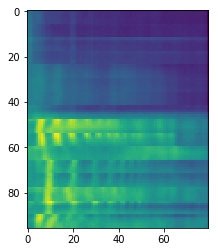

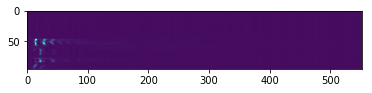

W0808 01:17:00.700230 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:17:02.000525 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:17:03.763927 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:17:06.257494 19780 optimizer_v2.py:979] Gradie

W0808 01:17:46.719707 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:17:48.053011 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:17:48.841191 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:17:50.588588 19780 optimizer_v2.py:979] Gradie

W0808 01:18:27.382966 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:18:29.148367 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:18:31.467895 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:18:32.831205 19780 optimizer_v2.py:979] Gradie

W0808 01:19:12.079142 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:19:12.949341 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:19:14.690737 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:19:16.073052 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00022566241, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 169.2 sec
01h 19m 48s


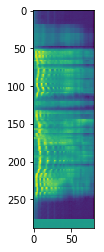

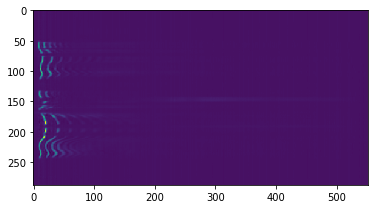

W0808 01:19:49.423645 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:19:51.283068 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:19:54.215736 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:19:55.510031 19780 optimizer_v2.py:979] Gradie

W0808 01:20:37.317550 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:20:39.137964 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:20:40.415256 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:20:42.207663 19780 optimizer_v2.py:979] Gradie

W0808 01:21:21.496609 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:21:22.764898 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:21:25.359489 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:21:27.159898 19780 optimizer_v2.py:979] Gradie

W0808 01:21:56.510581 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.0002814018, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.8 sec
01h 21m 56s


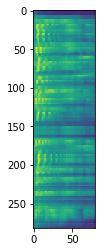

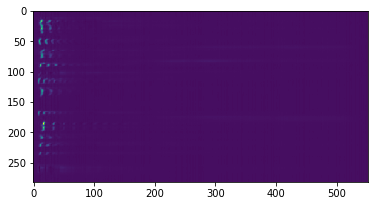

W0808 01:21:58.080939 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:21:59.863344 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:22:01.180644 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:22:02.886032 19780 optimizer_v2.py:979] Gradie

W0808 01:22:45.176661 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:22:46.530971 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:22:48.336381 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:22:49.628676 19780 optimizer_v2.py:979] Gradie

W0808 01:23:30.279932 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:23:32.132353 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:23:34.017782 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:23:35.288073 19780 optimizer_v2.py:979] Gradie

W0808 01:24:19.147058 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:24:21.888681 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:24:23.785113 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:24:26.668770 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.0002352452, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.2 sec
01h 24m 58s


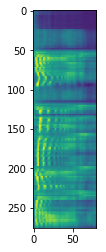

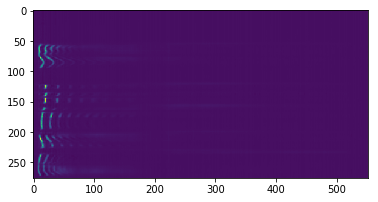

W0808 01:25:01.570717 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:25:02.940029 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:25:04.714432 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:25:06.581858 19780 optimizer_v2.py:979] Gradie

W0808 01:25:49.321589 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:25:50.618885 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:25:53.647573 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:25:55.450985 19780 optimizer_v2.py:979] Gradie

W0808 01:26:32.994533 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:26:34.726927 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:26:36.082237 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:26:37.887647 19780 optimizer_v2.py:979] Gradie

W0808 01:27:20.466342 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:27:23.650066 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:27:25.428472 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:27:26.759775 19780 optimizer_v2.py:979] Gradie

(16, 47)
tf.Tensor(0.00023776937, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.6 sec
01h 28m 01s


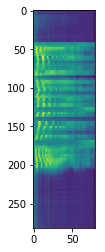

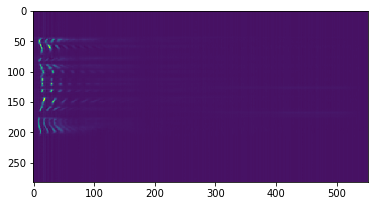

W0808 01:28:03.373111 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:28:06.141741 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:28:07.988162 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:28:09.353473 19780 optimizer_v2.py:979] Gradie

W0808 01:28:53.957628 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:28:55.813050 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:28:59.272839 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:29:00.557131 19780 optimizer_v2.py:979] Gradie

W0808 01:29:38.973877 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:29:40.255170 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:29:43.366878 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:29:45.223301 19780 optimizer_v2.py:979] Gradie

W0808 01:30:28.996267 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:30:30.278559 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:30:31.633868 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:30:34.033415 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00022340915, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 190.0 sec
01h 31m 11s


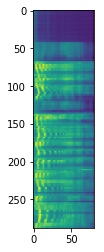

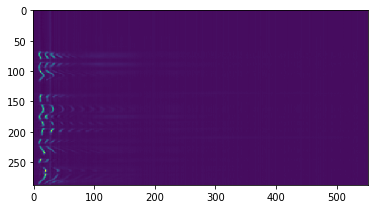

W0808 01:31:12.314131 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:31:15.202788 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:31:16.572100 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:31:18.381511 19780 optimizer_v2.py:979] Gradie

W0808 01:32:07.661732 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:32:09.438136 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:32:10.786444 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:32:13.660098 19780 optimizer_v2.py:979] Gradie

W0808 01:32:58.027200 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:32:59.821608 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:33:01.644023 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:33:04.168597 19780 optimizer_v2.py:979] Gradie

W0808 01:33:43.532560 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:33:45.307965 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:33:46.630266 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:33:48.419673 19780 optimizer_v2.py:979] Gradie

(16, 32)
tf.Tensor(0.00032859357, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 191.0 sec
01h 34m 22s


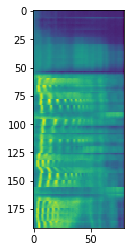

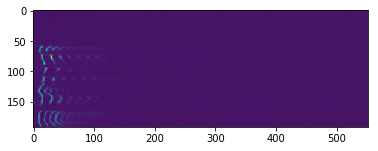

W0808 01:34:24.199820 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:34:25.483113 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:34:27.257517 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:34:28.595821 19780 optimizer_v2.py:979] Gradie

W0808 01:35:02.368510 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:35:04.141914 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:35:06.813522 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:35:08.163831 19780 optimizer_v2.py:979] Gradie

W0808 01:35:47.454776 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:35:48.746071 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:35:50.594491 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:35:53.128067 19780 optimizer_v2.py:979] Gradie

W0808 01:36:32.457023 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:36:33.271209 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:36:35.112627 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:36:36.385918 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00023378851, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 164.3 sec
01h 37m 06s


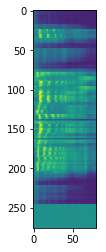

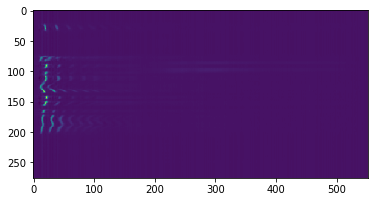

W0808 01:37:09.109367 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:37:10.385659 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:37:12.200071 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:37:13.990480 19780 optimizer_v2.py:979] Gradie

W0808 01:37:51.846098 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:37:53.132392 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:37:54.982813 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:37:56.308114 19780 optimizer_v2.py:979] Gradie

W0808 01:38:36.283216 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:38:38.073624 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:38:39.435934 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:38:41.231344 19780 optimizer_v2.py:979] Gradie

W0808 01:39:22.876825 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:39:24.664232 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:39:25.944524 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:39:27.736932 19780 optimizer_v2.py:979] Gradie

(16, 16)
tf.Tensor(0.0006721804, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 172.5 sec
01h 39m 59s


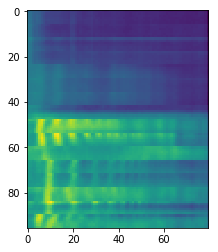

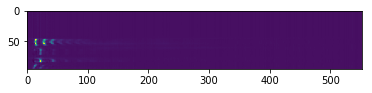

W0808 01:40:01.078523 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:40:02.374819 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:40:04.051200 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:40:06.617784 19780 optimizer_v2.py:979] Gradie

W0808 01:40:47.172019 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:40:48.506322 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:40:49.304504 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:40:51.077907 19780 optimizer_v2.py:979] Gradie

W0808 01:41:27.786266 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:41:29.607680 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:41:31.943211 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:41:33.205499 19780 optimizer_v2.py:979] Gradie

W0808 01:42:12.373418 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:42:13.169599 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:42:14.988013 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:42:16.350323 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00022385093, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 169.1 sec
01h 42m 48s


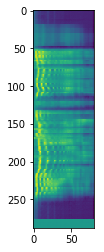

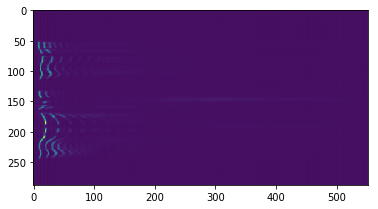

W0808 01:42:49.659907 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:42:51.441312 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:42:54.361977 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:42:55.729289 19780 optimizer_v2.py:979] Gradie

W0808 01:43:37.562813 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:43:39.371225 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:43:40.658519 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:43:42.430922 19780 optimizer_v2.py:979] Gradie

W0808 01:44:21.668855 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:44:22.959150 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:44:25.565743 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:44:27.304138 19780 optimizer_v2.py:979] Gradie

W0808 01:44:56.783851 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.0002789398, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.9 sec
01h 44m 56s


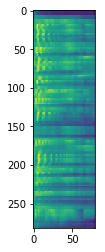

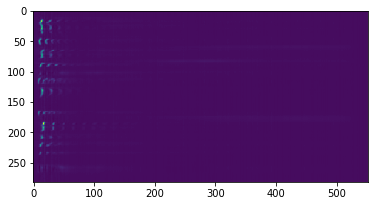

W0808 01:44:58.279192 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:45:00.141615 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:45:01.387900 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:45:03.190310 19780 optimizer_v2.py:979] Gradie

W0808 01:45:45.428926 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:45:46.799239 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:45:48.531633 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:45:49.873939 19780 optimizer_v2.py:979] Gradie

W0808 01:46:30.304145 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:46:32.193576 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:46:34.027993 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:46:35.382301 19780 optimizer_v2.py:979] Gradie

W0808 01:47:19.179273 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:47:21.985911 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:47:23.874341 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:47:26.776002 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00023225108, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 181.8 sec
01h 47m 58s


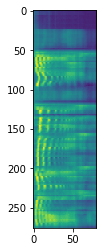

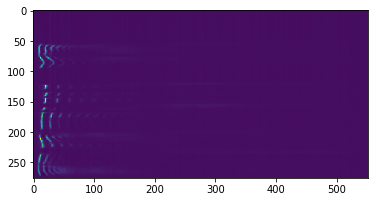

W0808 01:48:01.440895 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:48:02.729189 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:48:04.569608 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:48:06.449035 19780 optimizer_v2.py:979] Gradie

W0808 01:48:49.060738 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:48:50.359034 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:48:53.306704 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:48:55.091111 19780 optimizer_v2.py:979] Gradie

W0808 01:49:32.500629 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:49:34.221020 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:49:35.579329 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:49:37.442753 19780 optimizer_v2.py:979] Gradie

W0808 01:50:19.903422 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:50:23.109151 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:50:24.893557 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:50:26.214858 19780 optimizer_v2.py:979] Gradie

(16, 47)
tf.Tensor(0.00023559481, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.2 sec
01h 51m 00s


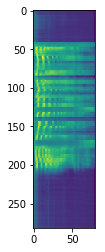

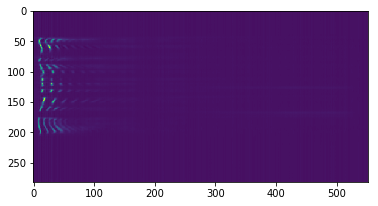

W0808 01:51:02.770182 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:51:05.620830 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:51:07.477253 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:51:08.765547 19780 optimizer_v2.py:979] Gradie

W0808 01:51:53.661769 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:51:55.520191 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:51:58.965977 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:52:00.238266 19780 optimizer_v2.py:979] Gradie

W0808 01:52:38.650012 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:52:39.927302 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:52:43.023007 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:52:44.875429 19780 optimizer_v2.py:979] Gradie

W0808 01:53:28.619389 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:53:29.902682 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:53:31.250989 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:53:33.599523 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.0002202209, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 190.1 sec
01h 54m 11s


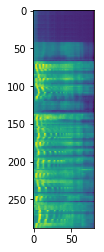

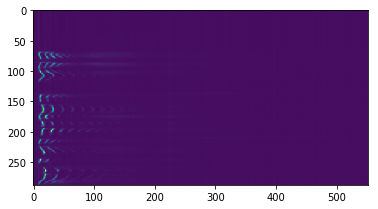

W0808 01:54:11.928251 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:54:14.824909 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:54:16.185220 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:54:17.976629 19780 optimizer_v2.py:979] Gradie

W0808 01:55:07.278852 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:55:09.055257 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:55:10.404565 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:55:13.288221 19780 optimizer_v2.py:979] Gradie

W0808 01:55:57.491286 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:55:59.270690 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:56:01.103109 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:56:03.632683 19780 optimizer_v2.py:979] Gradie

W0808 01:56:43.117673 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:56:44.906080 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:56:46.220381 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:56:48.011789 19780 optimizer_v2.py:979] Gradie

(16, 32)
tf.Tensor(0.0003265045, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 190.9 sec
01h 57m 21s


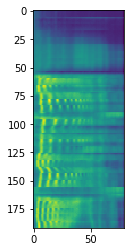

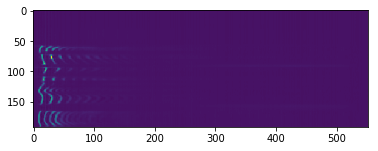

W0808 01:57:23.768931 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:57:25.068226 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:57:26.834627 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:57:28.172933 19780 optimizer_v2.py:979] Gradie

W0808 01:58:01.920617 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:58:03.701022 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:58:06.365628 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:58:07.729939 19780 optimizer_v2.py:979] Gradie

W0808 01:58:47.085900 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:58:48.365191 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:58:50.207611 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:58:52.757191 19780 optimizer_v2.py:979] Gradie

W0808 01:59:32.034135 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:59:32.834317 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:59:34.655731 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 01:59:35.943024 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.0002310527, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 164.1 sec
02h 00m 06s


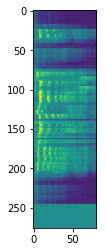

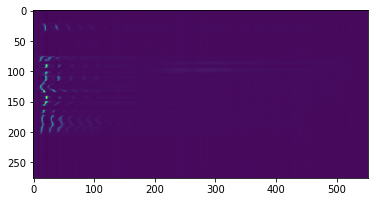

W0808 02:00:08.494436 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:00:09.751722 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:00:11.576137 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:00:13.370545 19780 optimizer_v2.py:979] Gradie

W0808 02:00:51.272175 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:00:52.565470 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:00:54.433895 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:00:55.722189 19780 optimizer_v2.py:979] Gradie

W0808 02:01:35.444233 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:01:37.220638 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:01:38.566944 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:01:40.340348 19780 optimizer_v2.py:979] Gradie

W0808 02:02:21.870804 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:02:23.646208 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:02:24.930500 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:02:26.713906 19780 optimizer_v2.py:979] Gradie

(16, 16)
tf.Tensor(0.00066799385, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 172.3 sec
02h 02m 58s


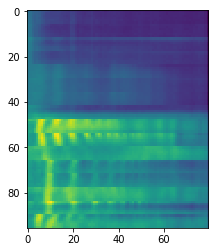

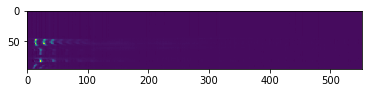

W0808 02:03:00.211533 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:03:01.522832 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:03:03.211216 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:03:05.773800 19780 optimizer_v2.py:979] Gradie

W0808 02:03:46.172997 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:03:47.441287 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:03:48.234468 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:03:50.009871 19780 optimizer_v2.py:979] Gradie

W0808 02:04:26.588201 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:04:28.419618 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:04:30.678132 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:04:32.022439 19780 optimizer_v2.py:979] Gradie

W0808 02:05:11.183354 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:05:11.979535 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:05:13.734935 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:05:15.102246 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00022222906, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 168.7 sec
02h 05m 47s


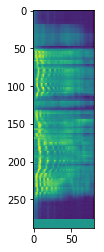

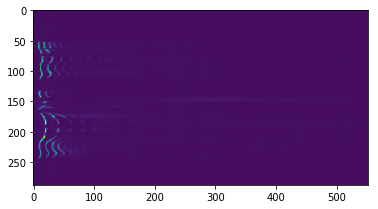

W0808 02:05:48.461842 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:05:50.310262 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:05:53.262934 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:05:54.554229 19780 optimizer_v2.py:979] Gradie

W0808 02:06:36.339742 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:06:38.159158 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:06:39.442449 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:06:41.223854 19780 optimizer_v2.py:979] Gradie

W0808 02:07:20.473792 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:07:21.745081 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:07:24.341673 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:07:26.152085 19780 optimizer_v2.py:979] Gradie

W0808 02:07:55.437752 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.


(16, 47)
tf.Tensor(0.00027871475, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 2.7 sec
02h 07m 55s


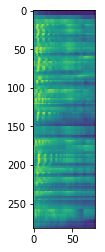

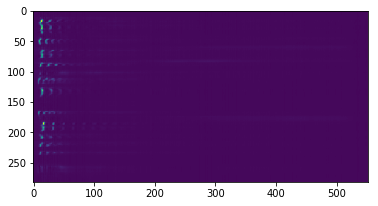

W0808 02:07:57.018113 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:07:58.883538 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:08:00.138822 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:08:01.935232 19780 optimizer_v2.py:979] Gradie

W0808 02:08:44.183852 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:08:45.554164 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:08:47.310563 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:08:48.649868 19780 optimizer_v2.py:979] Gradie

W0808 02:09:29.159091 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:09:31.012513 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:09:32.811923 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:09:34.146227 19780 optimizer_v2.py:979] Gradie

W0808 02:10:17.954201 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:10:20.760840 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:10:22.617263 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:10:25.445907 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00023185974, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.0 sec
02h 10m 57s


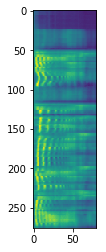

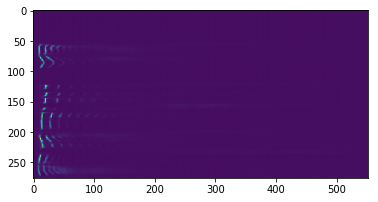

W0808 02:11:00.305844 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:11:01.680157 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:11:03.449560 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:11:05.314984 19780 optimizer_v2.py:979] Gradie

W0808 02:11:48.012706 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:11:49.317003 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:11:52.330689 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:11:54.111096 19780 optimizer_v2.py:979] Gradie

W0808 02:12:31.556621 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:12:33.339027 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:12:34.680333 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:12:36.467739 19780 optimizer_v2.py:979] Gradie

W0808 02:13:18.943410 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:13:22.200151 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:13:23.980558 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:13:25.234843 19780 optimizer_v2.py:979] Gradie

(16, 47)
tf.Tensor(0.00023401568, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 182.4 sec
02h 13m 59s


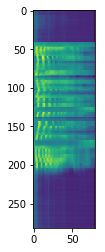

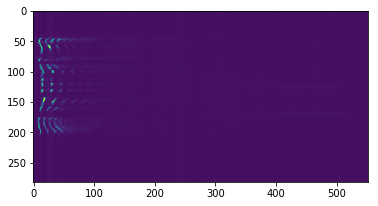

W0808 02:14:01.846179 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:14:04.712831 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:14:06.486236 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:14:07.852547 19780 optimizer_v2.py:979] Gradie

W0808 02:14:52.680753 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:14:54.531174 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:14:57.977959 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:14:59.254250 19780 optimizer_v2.py:979] Gradie

W0808 02:15:37.745013 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:15:39.024305 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:15:42.123010 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:15:44.043447 19780 optimizer_v2.py:979] Gradie

W0808 02:16:27.881429 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:16:29.242739 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:16:30.530032 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:16:33.006596 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00021623416, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 190.7 sec
02h 17m 10s


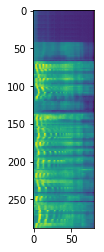

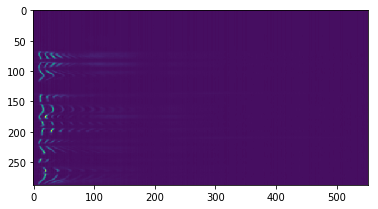

W0808 02:17:11.555374 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:17:14.454033 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:17:15.752328 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:17:17.620754 19780 optimizer_v2.py:979] Gradie

W0808 02:18:06.902975 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:18:08.745395 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:18:10.013683 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:18:12.903341 19780 optimizer_v2.py:979] Gradie

W0808 02:18:57.165420 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:18:58.951825 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:19:00.772240 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:19:03.290814 19780 optimizer_v2.py:979] Gradie

W0808 02:19:42.707789 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:19:44.485193 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:19:45.798492 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:19:47.610905 19780 optimizer_v2.py:979] Gradie

(16, 32)
tf.Tensor(0.00032305688, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 191.1 sec
02h 20m 21s


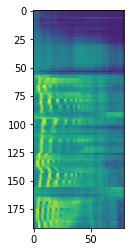

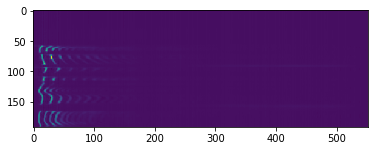

W0808 02:20:23.505078 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:20:24.814377 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:20:26.597781 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:20:27.929085 19780 optimizer_v2.py:979] Gradie

W0808 02:21:01.849809 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:21:03.629213 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:21:06.305822 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:21:07.680135 19780 optimizer_v2.py:979] Gradie

W0808 02:21:47.373173 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:21:48.657466 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:21:50.490883 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:21:53.010457 19780 optimizer_v2.py:979] Gradie

W0808 02:22:32.523453 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:22:33.360645 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:22:35.186059 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:22:36.547370 19780 optimizer_v2.py:979] Gradie

(16, 46)
tf.Tensor(0.00022974586, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 165.2 sec
02h 23m 06s


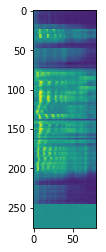

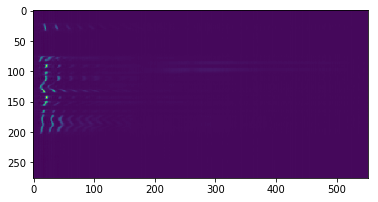

W0808 02:23:09.302828 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:23:10.653135 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:23:12.406535 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:23:14.270958 19780 optimizer_v2.py:979] Gradie

W0808 02:23:52.464655 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:23:53.748947 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:23:55.598369 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:23:56.913668 19780 optimizer_v2.py:979] Gradie

W0808 02:24:36.947783 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:24:38.732189 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:24:40.091500 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:24:41.873904 19780 optimizer_v2.py:979] Gradie

W0808 02:25:23.861464 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:25:25.664875 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:25:26.983175 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:25:28.783586 19780 optimizer_v2.py:979] Gradie

(16, 16)
tf.Tensor(0.000662486, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 173.3 sec
02h 26m 00s


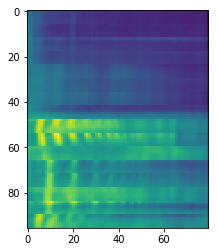

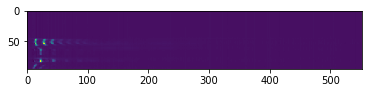

W0808 02:26:02.109174 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:26:03.413470 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:26:05.169870 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:26:07.698446 19780 optimizer_v2.py:979] Gradie

W0808 02:26:48.377708 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:26:49.653998 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:26:50.517195 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:26:52.197577 19780 optimizer_v2.py:979] Gradie

W0808 02:27:28.930942 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:27:30.773360 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:27:33.120895 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:27:34.381182 19780 optimizer_v2.py:979] Gradie

W0808 02:28:13.881175 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:28:14.685359 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:28:16.517776 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:28:17.817073 19780 optimizer_v2.py:979] Gradie

(16, 48)
tf.Tensor(0.00022006527, shape=(), dtype=float32)
Time taken for 100 * 16 samples: 169.8 sec
02h 28m 50s


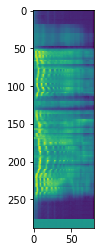

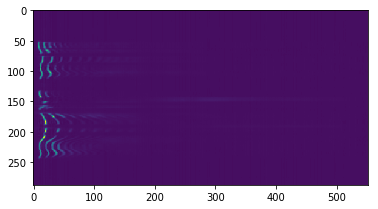

W0808 02:28:51.368712 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:28:53.238137 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:28:56.193809 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:28:57.479103 19780 optimizer_v2.py:979] Gradie

W0808 02:29:39.451659 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:29:41.254069 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:29:42.525359 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:29:44.306764 19780 optimizer_v2.py:979] Gradie

W0808 02:30:23.584709 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:30:24.926013 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:30:27.520605 19780 optimizer_v2.py:979] Gradients does not exist for variables ['decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/recurrent_kernel:0', 'decoder_rnn/stacked_residual_rnn/residual_gru/gru_2/bias:0'] when minimizing the loss.
W0808 02:30:29.253998 19780 optimizer_v2.py:979] Gradie

In [20]:
# Started hour
print(time.strftime("%Hh %Mm %Ss"))


for epoch in range(10):

    start = time.time()

    for i, (mel, linear, texts) in enumerate(tqdm((dataset))):

        loss, spec, mel = tacotron.train(mel, linear, texts)

        if i % 100 == 0:
            print(texts.shape)    
            print(loss)
            print('Time taken for 100 * 16 samples: {:.1f} sec'.format(time.time() - start))
            print(time.strftime("%Hh %Mm %Ss"))
            start = time.time()

            plt.figure()
            plt.imshow(spec[0])
            plt.show()

            plt.figure()
            plt.imshow(mel[0])
            plt.show()

            print('')